# Part B: Regression

**<font size=4>
Prediction Task**

**How is your prediction task defined?**

- We are given a dataset containing housing prices in the US with other attributes such as city, house area, renovation status, etc.
- The prediction task is to create a predicive regression model to predict the housing prices based of these attributes

**What is the meaning of the output variable?**

- The output variable is Price($)
- This is how much the house is sold at in dollars ($)
- As the output variable is a continuous (numerical) variable, we reuire a regression model


# Background Research

Incomplete

# References

* scikit link...
* pearson r link...
* background research link...
* dataset source

# Importing Libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set()


# Experimental
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve
from statsmodels.api import qqplot
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error, make_scorer

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter Tuning
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV, validation_curve, RandomizedSearchCV, ShuffleSplit


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, SequentialFeatureSelector, VarianceThreshold, mutual_info_regression, RFE

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
# random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

c:\Users\HP\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Defining Utitlity Functions

Functions that wil be used

- Plot learning curve
- Plot validation curve
- Plot outliers
- Countplot

In [2]:
def highlight_scores(x):
    max_val = x.max()
    min_val = x.min()
    return [
        "background-color: green; color: white" if v == max_val else "background-color: red; color: white" if v == min_val else ""
        for v in x
    ]


def outliers_count(df, feature):
  column = df[feature].apply(np.log)
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1
  LowerBound = Q1 - 1.5 * IQR
  UpperBound = Q3 + 1.5 * IQR
  outlier_mask = (column < LowerBound) | (column > UpperBound) #keep only outliers
  outlier_df = df[outlier_mask]
  return outlier_df.sort_values(feature)


def show_outliers(df, feature):
  column = df[feature].apply(np.log)
  x = df.copy()
  x[feature] = df[feature].apply(np.log)
  x.rename(columns={f'{feature}': f'{feature} (Log Transformed)'}, inplace=True)
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1
  LowerBound = Q1 - 1.5 * IQR
  UpperBound = Q3 + 1.5 * IQR
  outlier_mask = (column < LowerBound) | (column > UpperBound) #keep only outliers
  outlier_df = df[outlier_mask]
  print("Outliers in Series (First 5)")
  display(outlier_df.head())
  print("No. of Outliers:", len(outlier_df))
  sns.boxplot(y = f'{feature} (Log Transformed)', data = x, orient= "h")
  sns.despine(left = True)
  plt.title(f"Box Plot of {feature}")
  plt.show()


def model_evaluation_new(models, X_train, y_train, metrics, cv=KFold(n_splits=5, shuffle=True, random_state=42), curve=True):
    hist = []    
    
    for name, model in models:        
        
        cv_hist = cross_validate(model, X_train, y_train, scoring=metrics, return_train_score=True, n_jobs=-1)

        hist.append(dict(
            Model=name,
            fit_time = cv_hist['fit_time'].mean(),
            score_time = cv_hist['score_time'].mean(),
            train_neg_mean_absolute_error = cv_hist['train_neg_mean_absolute_error'].mean(),
            test_neg_mean_absolute_error = cv_hist['test_neg_mean_absolute_error'].mean(),
            train_neg_mean_absolute_percentage_error = cv_hist['train_neg_mean_absolute_percentage_error'].mean(),
            test_neg_mean_absolute_percentage_error = cv_hist['test_neg_mean_absolute_percentage_error'].mean(),
            train_neg_mean_squared_error = cv_hist['train_neg_mean_squared_error'].mean(),
            test_neg_mean_squared_error = cv_hist['test_neg_mean_squared_error'].mean(),
            # test_neg_root_mean_squared_error = cv_hist['neg_root_mean_squared_error'].mean(),
            train_r2 = cv_hist['train_r2'].mean(),
            test_r2 = cv_hist['test_r2'].mean()
        ))

        if curve:
          plot_learning_curve(model, name, X_train, y_train, metrics[0], cv)

    results = hist
    return pd.DataFrame(results)

def model_evaluation_single(model, X_train, y_train, metrics, cv=KFold(n_splits=5, shuffle=True, random_state=42), curve=True):
    hist = []    

    cv_hist = cross_validate(model, X_train, y_train, scoring=metrics, return_train_score=True, n_jobs=-1)

    hist.append(dict(
      # Model=model.get_params()['regressor'].__class__.__name__,
      fit_time = cv_hist['fit_time'].mean(),
      score_time = cv_hist['score_time'].mean(),
      train_neg_mean_absolute_error = cv_hist['train_neg_mean_absolute_error'].mean(),
      test_neg_mean_absolute_error = cv_hist['test_neg_mean_absolute_error'].mean(),
      train_neg_mean_absolute_percentage_error = cv_hist['train_neg_mean_absolute_percentage_error'].mean(),
      test_neg_mean_absolute_percentage_error = cv_hist['test_neg_mean_absolute_percentage_error'].mean(),
      train_neg_mean_squared_error = cv_hist['train_neg_mean_squared_error'].mean(),
      test_neg_mean_squared_error = cv_hist['test_neg_mean_squared_error'].mean(),
      # test_neg_root_mean_squared_error = cv_hist['neg_root_mean_squared_error'].mean(),
      train_r2 = cv_hist['train_r2'].mean(),
      test_r2 = cv_hist['test_r2'].mean()
    ))

    # if curve:
      # plot_learning_curve(model, name, X_train, y_train, metrics[0], cv)

    results = hist
    return pd.DataFrame(results)

def plot_learning_curve(model, title, X_train, y_train, metrics, cv, train_sizes=None, ax=None):
  if ax is None :
        fig, ax = plt.subplots(figsize=(10,8))

  train_sizes = np.linspace(.1, 1.0, 10)
  train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=f"{metrics}")
  scores = pd.DataFrame({
  "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
  "Train Scores" : train_scores.flatten(),
  "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve {title}")
  ax.set_ylabel(f'{metrics}')
  ax.set_xlabel("Train Sizes")
  plt.show()
        
def plot_learning_curve_comparison(model, title, X_train, y_train, metrics, cv, train_sizes=None, ax=None):
  if ax is None :
        fig, ax = plt.subplots(figsize=(10,8))

  train_sizes = np.linspace(.1, 1.0, 10)
  train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=f"{metrics}")
  scores = pd.DataFrame({
  "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
  "Train Scores" : train_scores.flatten(),
  "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve {title}")
  ax.set_ylabel(f'{metrics}')
  ax.set_xlabel("Train Sizes")
  

def plot_validation_curve(model, X, y, param_name, param_range, scoring="neg_mean_absolute_error", cv=KFold(shuffle=True, random_state = 42)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_scores, test_scores = validation_curve(model, X, y, param_name = param_name, param_range = param_range, scoring=scoring, n_jobs = -1)
  scores = pd.DataFrame({
      "Param Range" : np.tile(param_range, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Param Range"])
  
  sns.lineplot(data=scores, x="Param Range", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Validation Curve of {model_name} ({param_name})")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel(f"{param_name}")
  plt.show()

def cat_plot(df, features, figsize = (10, 20)):
    fig, ax = plt.subplots(len(features), 1, figsize=figsize, tight_layout = True)
    for idx, feature in enumerate(features):
        ax[idx].set_title("Counts of " + feature)
        # counts = df[feature].value_counts()
        sns.countplot(data = df, y = feature, ax = ax[idx])
    return fig

# Data Exploration

* Conduct an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.
* To prevent the mutation of original data, I will make a copy to perform EDA on it
* The data set is constructed from the housing infromation of 545 houses in the US

**Objectives for EDA**
- How many rows and how many columns are there
- Distribution of the target variable (Price ($))
- Distribution of the columns in our dataset
- Missing values present
- Outliers present
- Correlation between variables 
- Corerlation between variables and target variable (Price ($))

**Metadata**
* House ID: Unique house identifier ranging from 0 to 544
* City: Which city the house is located
* House Area: Size of the house in square meters
* No. of Bedrooms: How many bedrooms in the house
* No. of Toilets: How many toilets in the house
* Stories: The number of stories in the house
* Renovation Status: How well the house is renovated
* Price: The price of the house in US dollars

In [3]:
# Import the dataset
housing_df = pd.read_csv('../../datasets/housing_dataset.csv')
housing_df

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000
...,...,...,...,...,...,...,...,...
540,540,Seattle,300.0,2,1,1,unfurnished,182000
541,541,New York,240.0,3,1,1,semi-furnished,176715
542,542,Boston,362.0,2,1,1,unfurnished,175000
543,543,Seattle,291.0,3,1,1,furnished,175000


In [4]:
housing_eda = housing_df.copy()

# Descriptive Analysis

In [5]:
housing_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   House ID           545 non-null    int64  
 1   City               545 non-null    object 
 2   House Area (sqm)   545 non-null    float64
 3   No. of Bedrooms    545 non-null    int64  
 4   No. of Toilets     545 non-null    int64  
 5   Stories            545 non-null    int64  
 6   Renovation Status  545 non-null    object 
 7   Price ($)          545 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 34.2+ KB


- There are 545 rows and 8 columns in this dataset
- There appears to be no missing values in the dataset
- House ID contain identifiers for each house
- As this value does not provide any insight to my analysis, it would be best to drop this column


In [6]:
descriptive_stats = housing_eda.describe().T
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
House ID,545.0,272.000000,157.472220,0.0,136.0,272.0,408.0,544.0
House Area (sqm),545.0,515.054128,217.014102,165.0,360.0,460.0,636.0,1620.0
No. of Bedrooms,545.0,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
No. of Toilets,545.0,1.286239,0.502470,1.0,1.0,1.0,2.0,4.0
Stories,545.0,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
Price ($),545.0,476672.924771,187043.961566,175000.0,343000.0,434000.0,574000.0,1330000.0


- House Area (sqm) is likely to be postively skewed with outliers as the max area is larger than the upper quartile (75%)
- Similarly, Price($) is likely to be positively skewed as well, becuase the max housing price is much larger compared to the upper quartile (75%)
- House Area (sqm) and Price ($) are both continuous variables 
- Apart from that, No. of Bedrooms, No. of Toilets and Stories are all discrete variables

# Univariate Analysis

**Target Variable Distribution: Price($)**

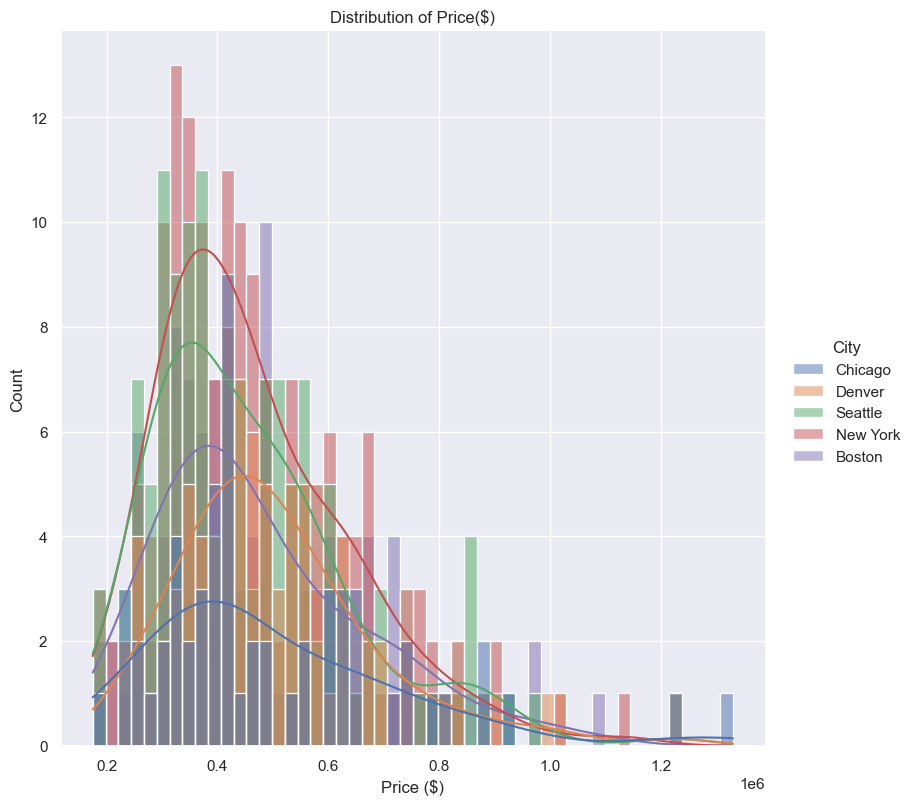

In [7]:
sns.displot(data=housing_eda, x="Price ($)", kde=True, hue="City", bins=50, height=8)
plt.title("Distribution of Price($)")
plt.show()
     

- The distribution of Price ($) is positvely skewed
- The most expensive houses are in New York
- The least expensive houses are in Chicago
- Most houses are less than $700K USD, but some house can cost up to over $1.2M USD
- Let's try to deskew it using a log scaler

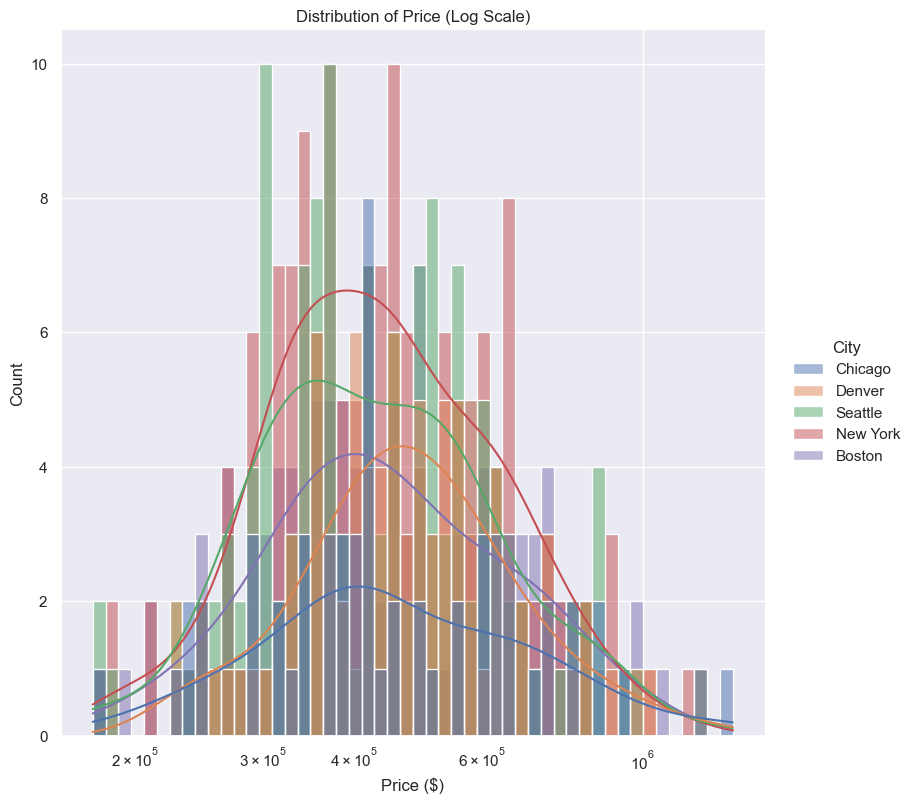

In [8]:
sns.displot(data=housing_eda, x="Price ($)", kde=True, hue="City", log_scale=True, bins=50, height = 8)
plt.title("Distribution of Price (Log Scale)")
plt.show()

- After performing log scaling, the prices seem to follow a normal distribution
- Suggests that the prices of these houses follow a log normal distribution
- (Log) Transformation of the target variable may improve the performance of the model 

**Continuous Variables**

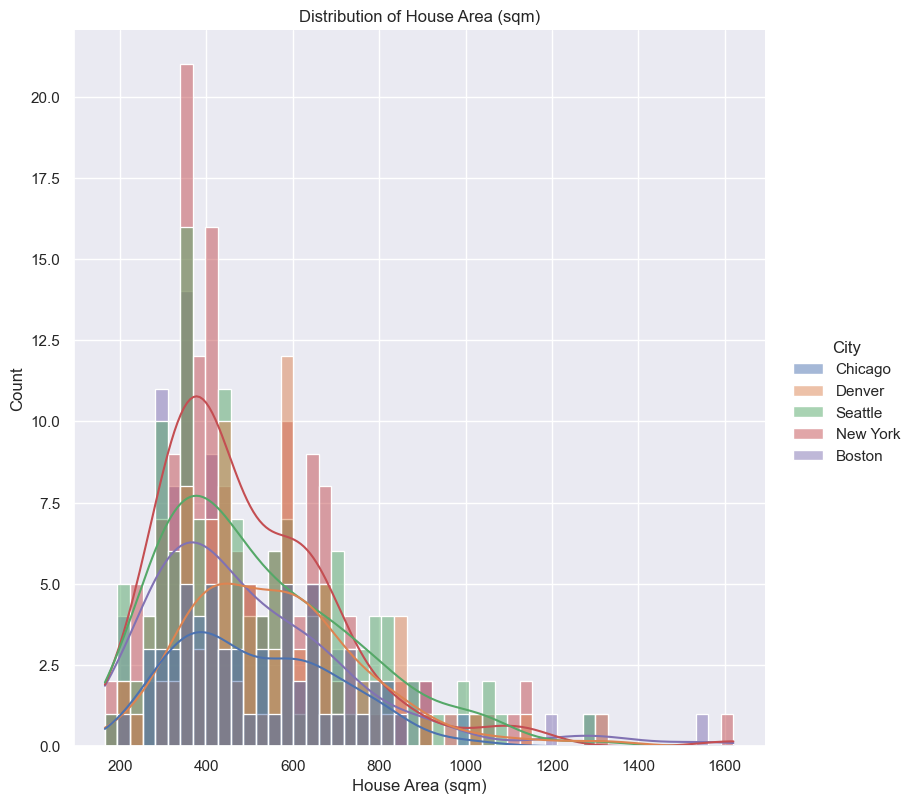

In [9]:
sns.displot(data=housing_eda, x="House Area (sqm)", kde=True, hue="City", bins=50, height=8)
plt.title("Distribution of House Area (sqm)")
plt.show()

- Observing the house area, we notice that it is positively-skewed
- Houses in each city tend to have houses of area between 300 sqm and 500 sqm

**Discrete Variables**

**Count Plots of features**

**Quantitative Features:**

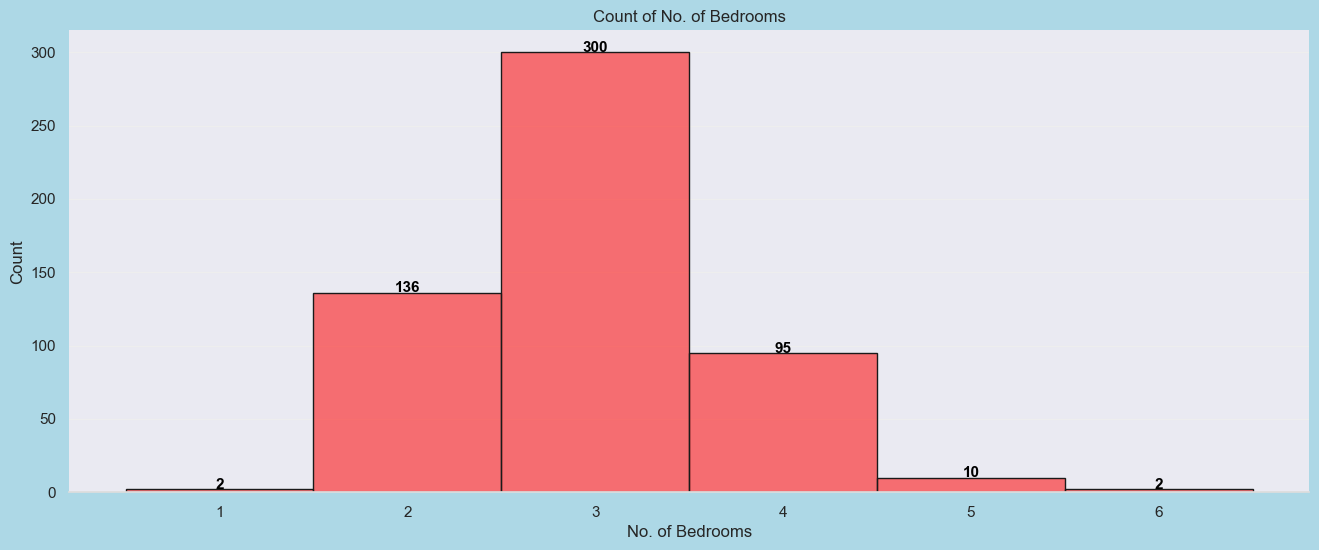

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16,6), facecolor='lightblue')

bedroom_counts = housing_eda['No. of Bedrooms'].value_counts().sort_index()
x_values = np.arange(len(bedroom_counts))

a = plt.bar(
    x_values,
    bedroom_counts,
    color='#ff000088',
    edgecolor='k',
    width=1
)

plt.xticks(x_values, bedroom_counts.index)
plt.xlabel('No. of Bedrooms')
plt.ylabel('Count')
plt.title('Count of No. of Bedrooms')

# Format axisb
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Remove ticks
ax.tick_params(bottom=False, left=False)  

# Add a horizontal grid
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE') #grey lines
ax.xaxis.grid(False)

for bar in a:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height()+0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      weight='bold',
      fontsize=11
)
plt.show()


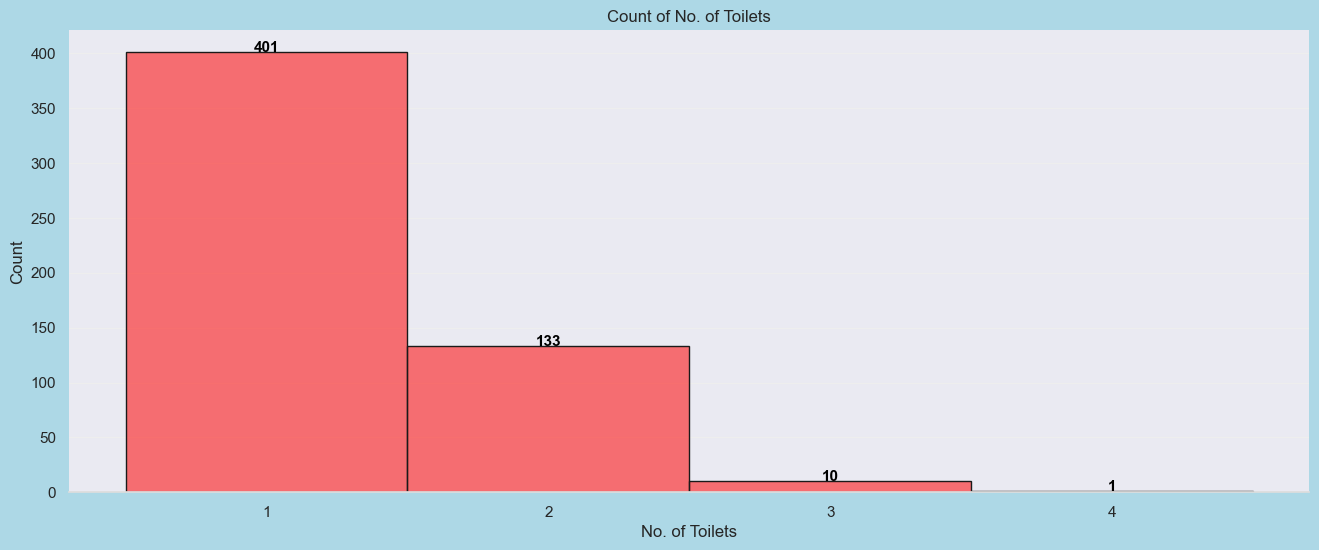

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16,6), facecolor='lightblue') 

toilet_counts = housing_eda['No. of Toilets'].value_counts().sort_index()
x_values = np.arange(len(toilet_counts))

b = plt.bar(
    x_values,
    toilet_counts,
    color='#ff000088',
    edgecolor='k',
    width=1
)

plt.xticks(x_values, toilet_counts.index)
plt.xlabel('No. of Toilets')
plt.ylabel('Count')
plt.title('Count of No. of Toilets')

# Format axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Remove ticks
ax.tick_params(bottom=False, left=False)  

# Add a horizontal grid
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE') #grey lines
ax.xaxis.grid(False)

for bar in b:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height()+0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      weight='bold',
      fontsize=11
)
plt.show()

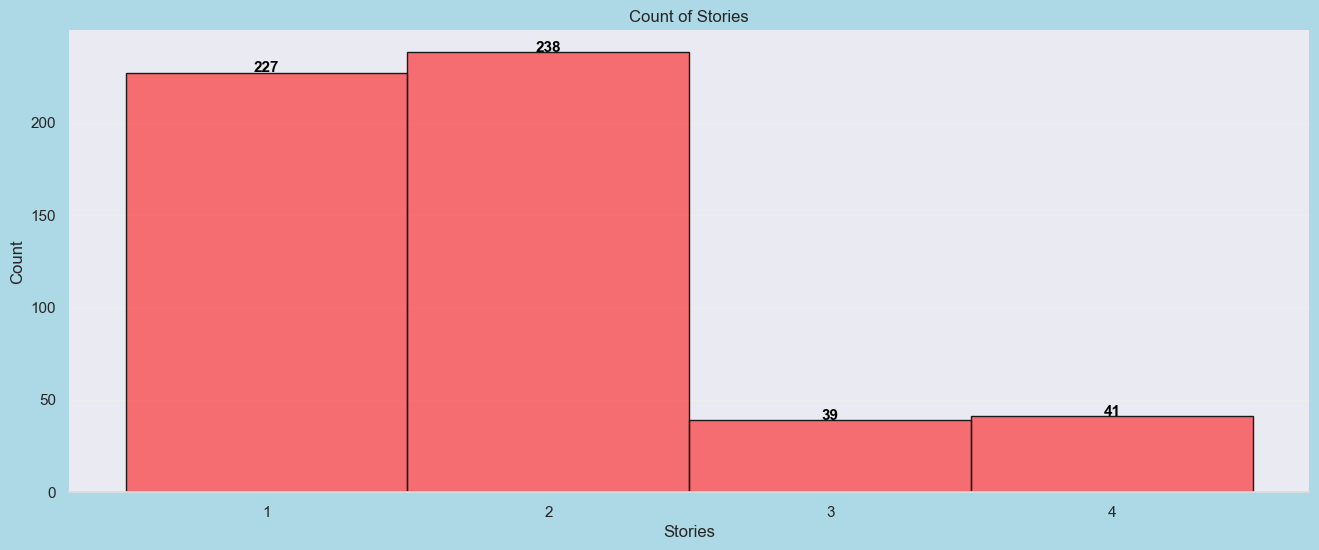

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16,6), facecolor='lightblue') 

stories = housing_eda['Stories'].value_counts().sort_index()
x_values = np.arange(len(stories))

c = plt.bar(
    x_values,
    stories,
    color='#ff000088',
    edgecolor='k',
    width=1
)

plt.xticks(x_values, stories.index)
plt.xlabel('Stories')
plt.ylabel('Count')
plt.title('Count of Stories')

# Format axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Remove ticks
ax.tick_params(bottom=False, left=False)  

# Add a horizontal grid
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE') #grey lines
ax.xaxis.grid(False)

for bar in c:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height()+0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      weight='bold',
      fontsize=11
)
plt.show()

**Qualitative Features**

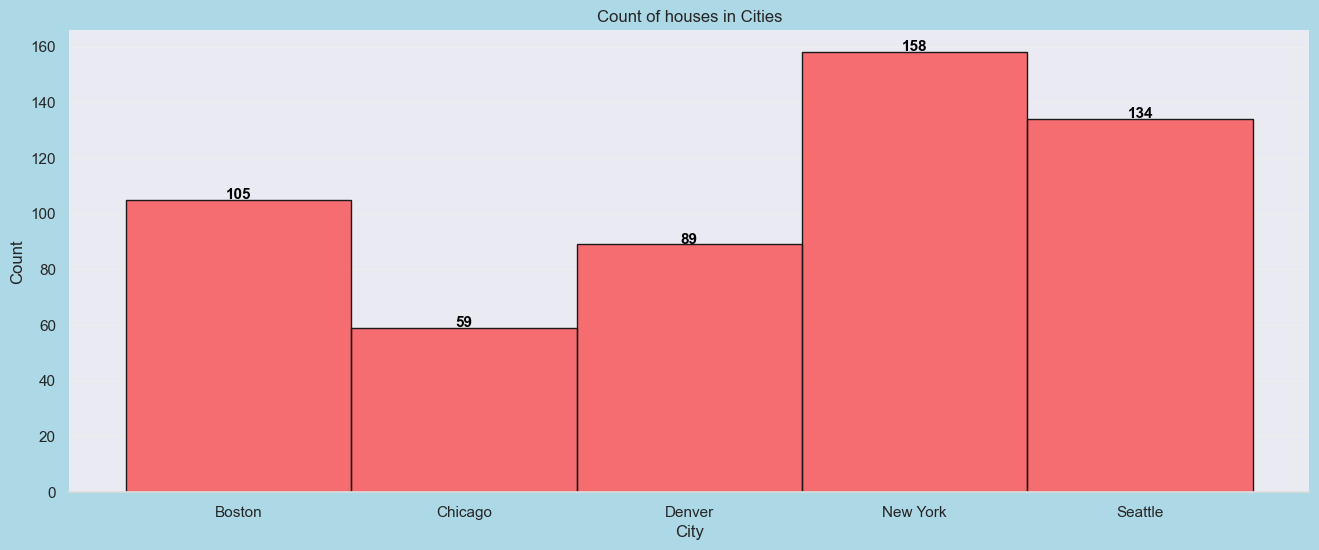

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16,6), facecolor='lightblue') 

city = housing_eda['City'].value_counts().sort_index()
x_values = np.arange(len(city))

d = plt.bar(
    x_values,
    city,
    color='#ff000088',
    edgecolor='k',
    width=1
)

plt.xticks(x_values, city.index)
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Count of houses in Cities')

# Format axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Remove ticks
ax.tick_params(bottom=False, left=False)  

# Add a horizontal grid
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE') #grey lines
ax.xaxis.grid(False)

for bar in d:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height()+0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      weight='bold',
      fontsize=11
)
plt.show()

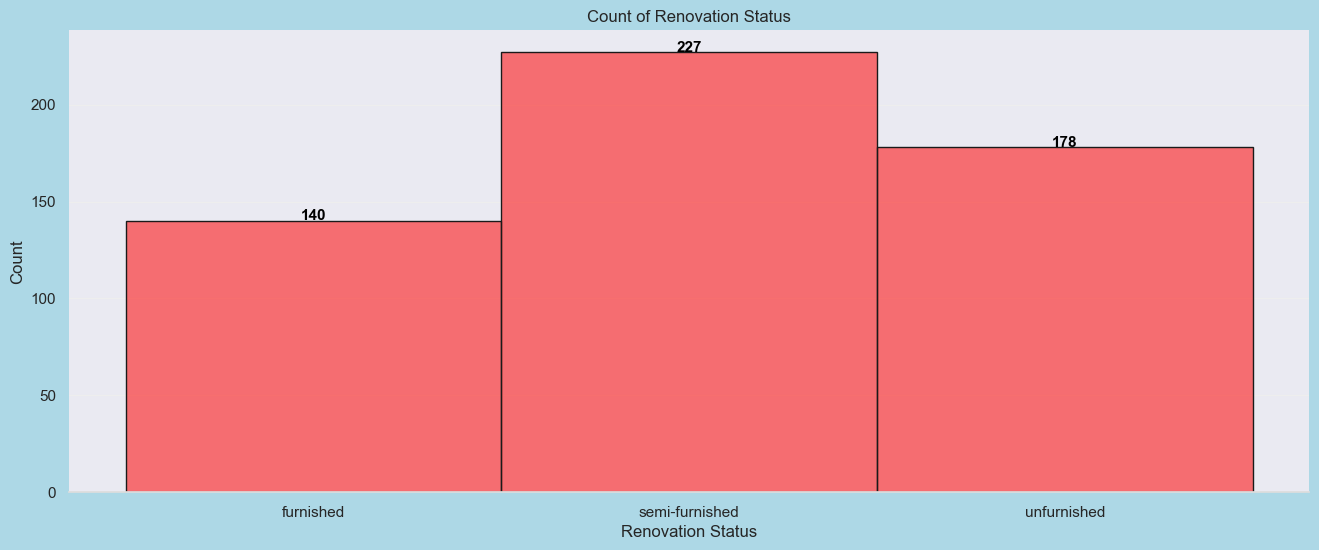

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16,6), facecolor='lightblue') 

status = housing_eda['Renovation Status'].value_counts().sort_index()
x_values = np.arange(len(status))

e = plt.bar(
    x_values,
    status,
    color='#ff000088',
    edgecolor='k',
    width=1
)

plt.xticks(x_values, status.index)
plt.xlabel('Renovation Status')
plt.ylabel('Count')
plt.title('Count of Renovation Status')

# Format axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Remove ticks
ax.tick_params(bottom=False, left=False)  

# Add a horizontal grid
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE') #grey lines
ax.xaxis.grid(False)

for bar in e:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height()+0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='black',
      weight='bold',
      fontsize=11
)
plt.show()

- The count plots tell us that most houses have:
    - 3 Bedrooms
    - 1 Toilet
    - 2 Stories
- Most houses are also located in New York
- Most houses also have a renovation status of semi-furnished

**Box Plots**

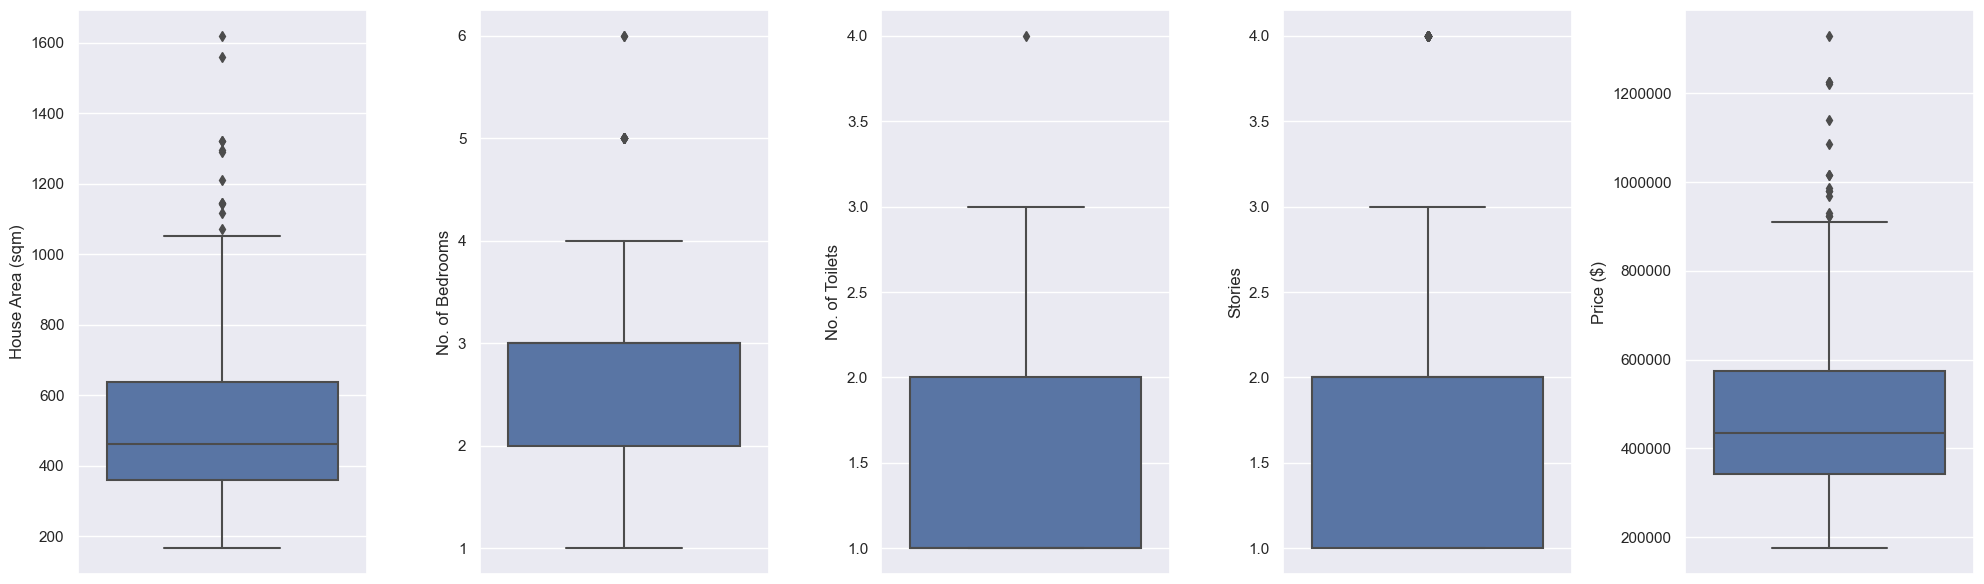

In [15]:
features = ['House Area (sqm)', 'No. of Bedrooms', 'No. of Toilets', 'Stories', 'Price ($)']

fig, ax = plt.subplots(1, len(features), figsize=(20, 6), tight_layout = True)

for idx, col in enumerate(features):
    ax[idx].ticklabel_format(useOffset=False, style='plain') # do not use scientific notation
    sns.boxplot(data = housing_eda, y=col, ax = ax[idx])
plt.show()


- The box plots are able to tell us more about the distribution of features
- We observe:
    - Most of these numerical features follow a similar positive distribution
    - All features have high or positve outliers
    - Price ($) has a few extreme outliers present

**Outlier and Anomaly Investigation**

- Our EDA has shown us that our data has quite a few outliers present
- We investigate these outliers for the purpose of data cleansing later on
- This is because we want our model to be able to perform accurate predictions and having many outliers will affect our models performance and the overall evaluation of the model

**Identifying the the features with the most outliers**
- Apply log transformation to our data and find outliers using Tukey's Fences (Upper & Lower Fences)

In [16]:
fliers = []

for feature in features:
    fliers.append(len(outliers_count(housing_eda, feature)))


In [17]:
pd.Series(fliers, index=features).sort_values()

No. of Toilets      0
Stories             0
Price ($)           1
House Area (sqm)    2
No. of Bedrooms     4
dtype: int64

- Note that these are the outliers present after performing log transformation on the features 
- From this we see that the main source of outliers come from No. of Bedrooms, House Area (sqm) and Price ($)
- We will continue by looking at these outliers further in depth 

**Investigating outliers**

- First we will look at the feature contribution to the largest amount of outliers, that is the No. of Bedrooms

Outliers in Series (First 5)


,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
112,112,Seattle,430.0,6,2,2,furnished,608300
395,395,New York,360.0,6,1,2,unfurnished,350000
445,445,Boston,345.0,1,1,1,furnished,315000
528,528,Chicago,397.0,1,1,1,unfurnished,227500


No. of Outliers: 4


c:\Users\HP\anaconda3\lib\site-packages\seaborn\_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


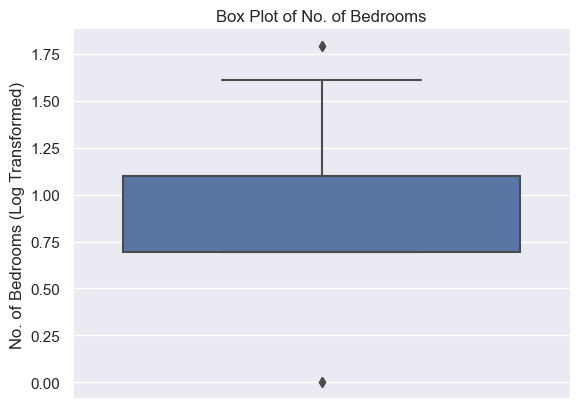

In [18]:
show_outliers(housing_eda, 'No. of Bedrooms')


- We see that that there aren't actually that many outliers (4)
- From this we can infer that most houses have 2-5 bedrooms and few houses have either 1 or 6 of them
- There seems nothing strange with these outliers and we continue investigating the next source of outliers: House Area (sqm)

Outliers in Series (First 5)


,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
7,7,New York,1620.0,5,3,2,unfurnished,1015000
125,125,Boston,1560.0,3,1,1,semi-furnished,594300


No. of Outliers: 2


c:\Users\HP\anaconda3\lib\site-packages\seaborn\_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


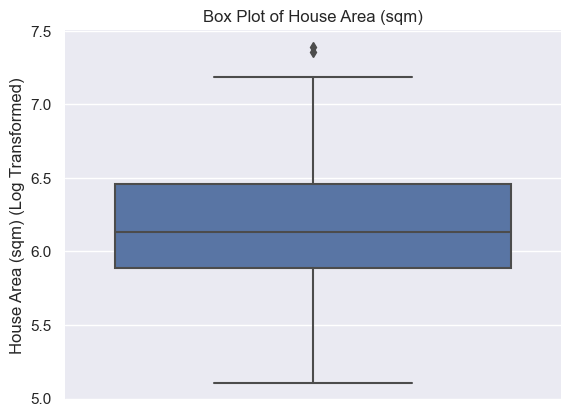

In [19]:
show_outliers(housing_eda, 'House Area (sqm)')


- For House Area (sqm), there are only 2 outliers
- These are the houses with the two largest areas out of all houses in the dataset
- One thing that separates both of them is Price ($), which seems to be much higher for the house with 1620 sqm compared to the one with 1560 sqm
- We continue investigating the next outlier: Price ($)
 

Outliers in Series (First 5)


,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000


No. of Outliers: 1


c:\Users\HP\anaconda3\lib\site-packages\seaborn\_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


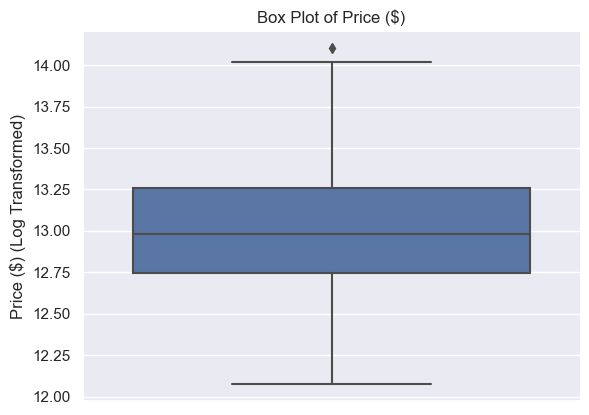

In [20]:
show_outliers(housing_eda, 'Price ($)')


- Lastly, we observe that Price ($) only has one outlier and it seems to be the house with the highest price
- One interesting observation is that the price of the house is very high, however compared to the outliers found in House Area (sqm), it's house area is much smaller
- Apart from that, there does not seem to be anything perculiar about this outlier


**Conclusion (Outlier Investigation)**

- After applying log transformation to our data, I was left with 'extreme' outliers
- After investigating these outliers, I can conclude a few things:
    - There are very little outliers (with respect to the dataset)
    - None of the outliers present have any anomalies
    - Some interesting observations were made, such as how the price of houses with different areas differed
- All in all, I will be choosing to not handle these outliers and leaving them be
- One thing this has told me is that log transformation is able to deskew our data well
- The presences of these outliers should not greatly influence the results of our prediction

# Bivariate Analysis

- Now let us see the relationship between features in our data

C:\Users\HP\AppData\Local\Temp\ipykernel_16104\2695031399.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(housing_eda.corr(), annot=True, linewidths=.5, cmap='BuPu', ax=ax)


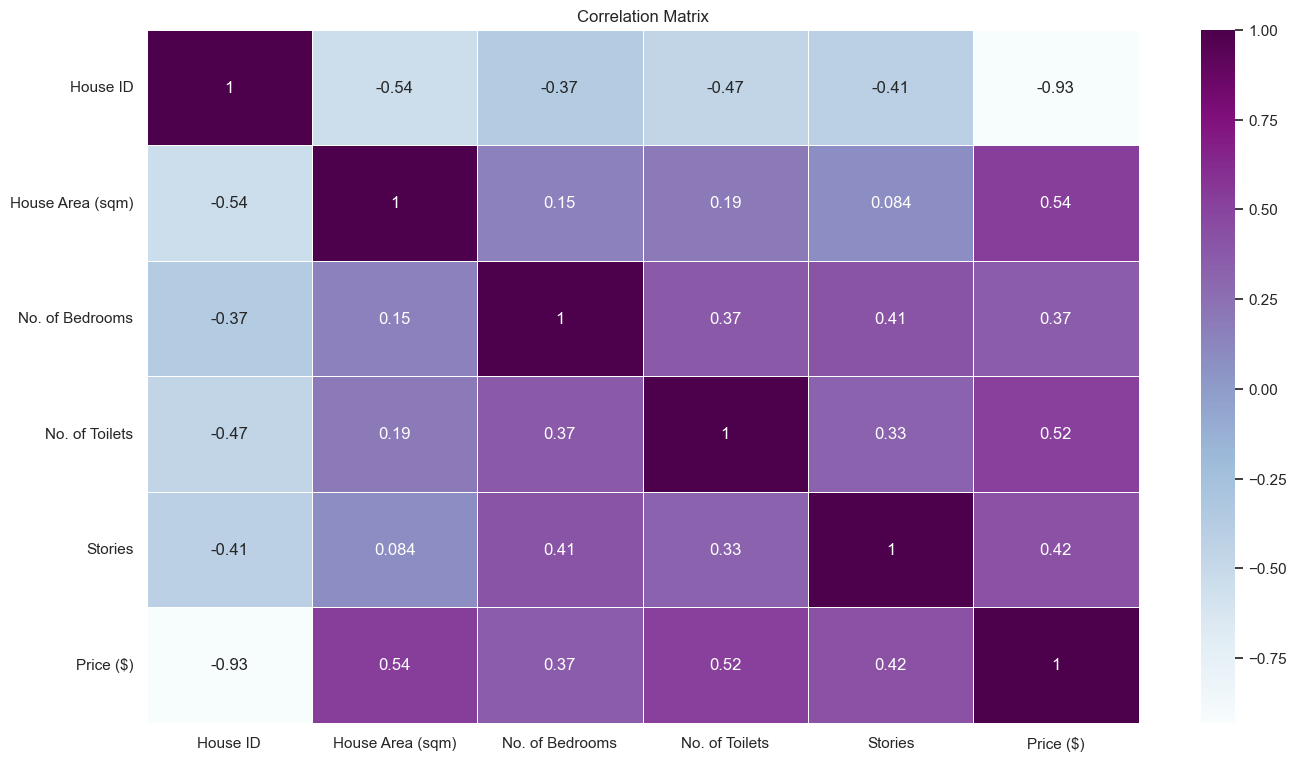

In [21]:

fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(housing_eda.corr(), annot=True, linewidths=.5, cmap='BuPu', ax=ax)
plt.title('Correlation Matrix')
plt.show()

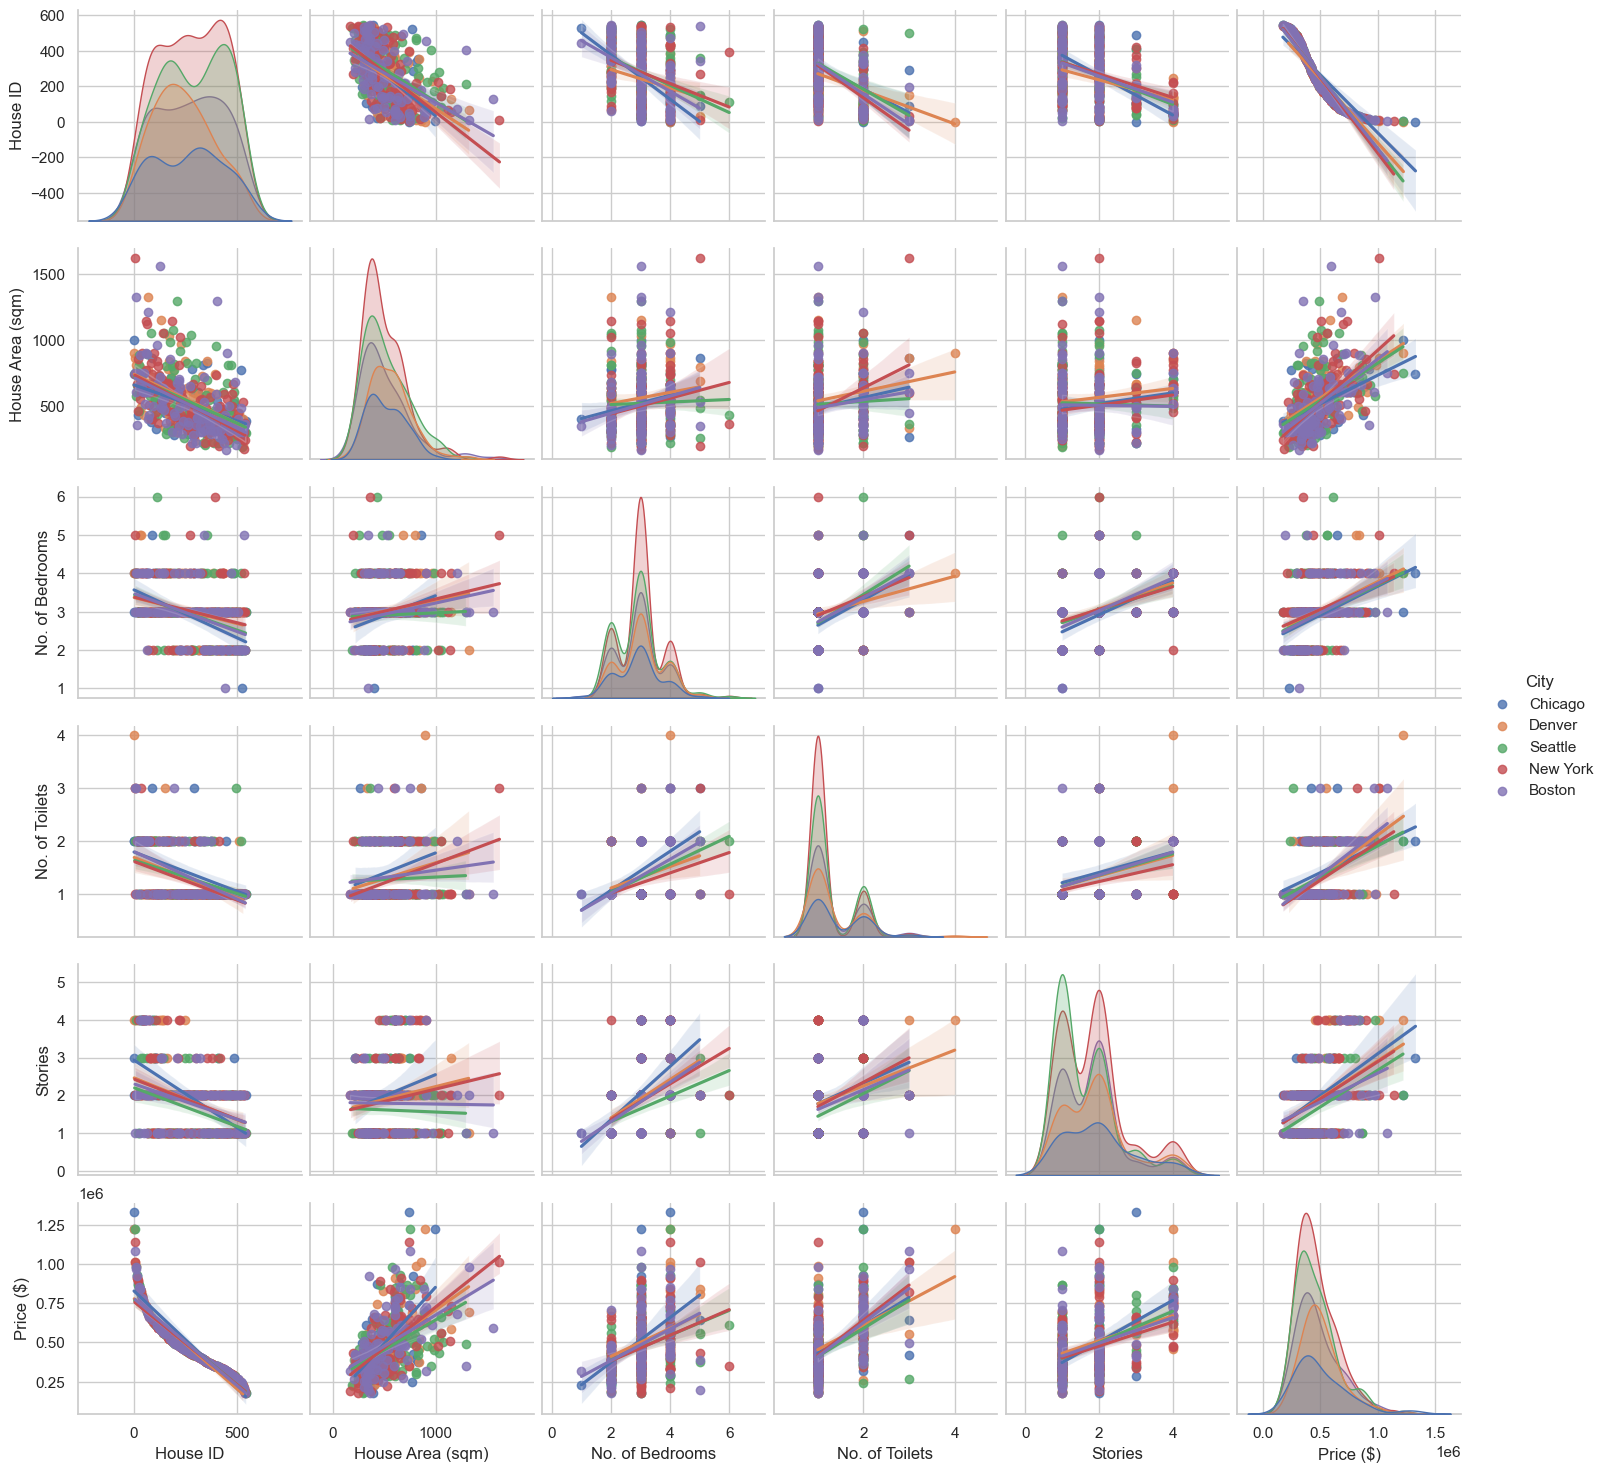

In [22]:
sns.set(style="whitegrid")
sns.pairplot(data=housing_eda, kind='reg', diag_kind='kde', hue='City')
plt.show()

From the heatmap we note:
- The most correlated feature with Price ($) is House Area (sqm), followed by No. of Toilets, then Stories and lastly No. of Bedrooms
- Apart from that, the correlation between features in the dataset are relative weak

# Data Preprocessing

**Did you process your features in any ways?**

- With the insights provided to us after EDA, we will proceed with data preprocessing as follows
- Steps:
    1) Separate Features from Target Variable
    2) Drop useless columns
    3) Encoding categorical variables
    4) Train Test Split
    5) Scaling

- Note that we do not have a step to handle outliers, this is because from the EDA we note that log transformation already greatly reduced the number of outliers
- Thus, we may implement that later on (part of model improvement)
- Lastly, the steps will ultimately be carried out using a pipeline, and the steps done above will serve the purpose of showing how the data is prepared

**Separating Features and Target Variable**

In [23]:
X = housing_df.drop(['Price ($)'], axis=1)
y = housing_df[['Price ($)']]

In [24]:
X

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status
0,0,Chicago,742.0,4,2,3,furnished
1,1,Denver,896.0,4,4,4,furnished
2,2,Chicago,996.0,3,2,2,semi-furnished
3,3,Seattle,750.0,4,2,2,furnished
4,4,New York,742.0,4,1,2,furnished
...,...,...,...,...,...,...,...
540,540,Seattle,300.0,2,1,1,unfurnished
541,541,New York,240.0,3,1,1,semi-furnished
542,542,Boston,362.0,2,1,1,unfurnished
543,543,Seattle,291.0,3,1,1,furnished


**Dropping useless columns**

In [25]:
X.drop(["House ID"], axis=1, inplace=True)

- We will drop House ID as it is a unique identifier and based off observations from our EDA, has very little contribution

**Encoding Categorical Variables**

- We will encode the feature: City using pandas dummies

In [26]:
# Education 
city_dummies = pd.get_dummies(X['City'], drop_first=True)
reno_dummies = pd.get_dummies(X['Renovation Status'], drop_first=True)

print(city_dummies.head(10))
print(reno_dummies.head(10))

   Chicago  Denver  New York  Seattle
0        1       0         0        0
1        0       1         0        0
2        1       0         0        0
3        0       0         0        1
4        0       0         1        0
5        0       0         0        0
6        0       1         0        0
7        0       0         1        0
8        0       1         0        0
9        0       0         0        1
   semi-furnished  unfurnished
0               0            0
1               0            0
2               1            0
3               0            0
4               0            0
5               1            0
6               1            0
7               0            1
8               0            0
9               0            1


In [27]:
# Concat
X = pd.concat([X, city_dummies], axis=1)
X = pd.concat([X, reno_dummies], axis=1)

In [28]:
# Drop columns
X = X.drop('City', axis=1)
X = X.drop('Renovation Status', axis=1)

In [29]:
X.head()

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Chicago,Denver,New York,Seattle,semi-furnished,unfurnished
0,742.0,4,2,3,1,0,0,0,0,0
1,896.0,4,4,4,0,1,0,0,0,0
2,996.0,3,2,2,1,0,0,0,1,0
3,750.0,4,2,2,0,0,0,1,0,0
4,742.0,4,1,2,0,0,1,0,0,0


**Train-Test Split**

In [30]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True,random_state = 42)

X_training = X_train.copy()
y_training = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_training

(436, 10) (436, 1)
(109, 10) (109, 1)


,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Chicago,Denver,New York,Seattle,semi-furnished,unfurnished
46,600.0,3,2,4,0,0,1,0,0,0
93,720.0,3,2,1,0,1,0,0,1,0
335,381.6,2,1,1,1,0,0,0,0,0
412,261.0,3,1,2,0,0,0,0,0,1
471,375.0,3,1,2,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
71,600.0,4,2,4,0,0,0,0,0,1
106,545.0,4,2,1,0,0,0,1,1,0
270,450.0,3,2,3,0,0,0,1,0,0
435,404.0,2,1,1,0,0,1,0,0,1


* To evaluate the chosen models, we do a train-test split of the data (80:20 ratio)
* We then train the model with the train data (80%)
* This allows me to simulate how my model would perform with new data or test data (20%)
* Create a copy the the training data to perform preproccesing on before implementing a pipepline when training the final model

**Scaling**

- For now we will perform Standardization on our data first
- In the further model section sgement, we will explore how different scaling affects our model's performance
- Furthermore, we will implement transformations to our data as well and observe it's performance

In [31]:
features = ['House Area (sqm)', 'No. of Bedrooms', 'No. of Toilets', 'Stories']
 
scaler = StandardScaler()

for feature in features:
    X_training[feature] = X_training[feature].astype(float)

X_training[features] = scaler.fit_transform(X_training[features])

In [32]:
X_training

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Chicago,Denver,New York,Seattle,semi-furnished,unfurnished
46,0.384168,0.055271,1.539173,2.587644,0,0,1,0,0,0
93,0.929181,0.055271,1.539173,-0.912499,0,1,0,0,1,0
335,-0.607755,-1.283514,-0.557950,-0.912499,1,0,0,0,0,0
412,-1.155492,0.055271,-0.557950,0.254215,0,0,0,0,0,1
471,-0.637730,0.055271,-0.557950,0.254215,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
71,0.384168,1.394055,1.539173,2.587644,0,0,0,0,0,1
106,0.134371,1.394055,1.539173,-0.912499,0,0,0,1,1,0
270,-0.297097,0.055271,1.539173,1.420929,0,0,0,1,0,0
435,-0.506019,-1.283514,-0.557950,-0.912499,0,0,1,0,0,1


# Model Selection

**How did you select which learning algorithms to use?**

**<font size=3>
Evaluation Methodology**

* I'll be using k-Fold Cross Validation to select candidate models after using data from the training-set
* I will then evaluate the final model using the test-set

**<font size=3>
Scoring Metrics**



* Mean Absolute Error(MAE):
    - MAE is the magnitude of difference between the prediction of an observation and the true value of that observation

* Mean Absolute Percentage Error(MAPE):
    - MAPE is the percentage equivalent of MAE

* Mean Squared Error(MSE):
    - MSE is the average squared difference between the estimated values and the actual values

* Root Mean Squared Error(RMSE):
    - RMSE is the square rooted result of MSE

* R2 Score:
    - R2 score is the coefficient of determination

**Optimizing Metric**

* The metric we will be mainly focusing on is **MAE** 

**Mean Absolute Error**

Mean Absolute Error (MAE) is defined by:

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$$


where 
* $n$ = is the total number of data points
* $y_i$ = the actual (true) value of the target variable for the $i$ th data point 
* $\bar{y_i}$ = the predicted value of the target variable for the $i$ th data point
* $\sum$ = summation over all data points
* $∣⋅∣$ = represents the absolute value

We choose MAE becuase:
* MAE does not heavily penalize the model when there are extreme outliers (i.e. the model makes large errors in predictions due to being influenced by outliers)  
* The result is directly intepretable as the average error of our model (does not square error)

**Pre Proccessing Pipeline settings**

In [33]:
ss = StandardScaler()

In [34]:
metrics = ["neg_mean_absolute_error","neg_mean_absolute_percentage_error", "neg_mean_squared_error", "r2"]
kf = KFold(n_splits=5,shuffle=True,random_state=42)

- Now we will test different models and select the best candidate models
- We will note the train and cross validation scores on the training set for selection

**Models**
- Linear Models: 
    - Linear Regression , BayesianRidge , SGDRegressor 
- DecisionTree Models: 
    - DecisionTreeRegressor 
- Ensemble Tree Models: 
    - RandomForest, ExtraTreesRegressor, GradientBoosting, HistGradientBoostingRegressor
- SVMs: 
    - linear, rbf, poly, sigmoid
- Distance Based Models: 
    - KNeighborsRegressor

**Viewing Scores**

In [35]:
DummyRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', DummyRegressor(strategy='median'))
])

LinearRegression_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', LinearRegression())
])

BayesianRidge_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', BayesianRidge())
])

SGDRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', SGDRegressor())
])

DecisionTreeRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', DecisionTreeRegressor())
])

RandomForestRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', RandomForestRegressor())
])

ExtraTreesRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', ExtraTreesRegressor())
])

GradientBoostingRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', GradientBoostingRegressor())
])

HistGradientBoostingRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', HistGradientBoostingRegressor())
])

KNeighborsRegressor_pipeline = Pipeline([
    ('Data Preprocessing', ss),
    ('Model', KNeighborsRegressor())
])

models = [
    ("DummyRegressor", DummyRegressor_pipeline),
    ("LinearRegression", LinearRegression_pipeline), 
    ("BayesianRidge", BayesianRidge_pipeline), 
    ("SGDRegressor", SGDRegressor_pipeline),
    ("DecisionTreeRegressor", DecisionTreeRegressor_pipeline), 
    ("RandomForestRegressor", RandomForestRegressor_pipeline),
    ("ExtraTreesRegressor", ExtraTreesRegressor_pipeline),
    ("GradientBoostingRegressor", GradientBoostingRegressor_pipeline),
    ("HistGradientBoostingRegressor", HistGradientBoostingRegressor_pipeline),
    ("KNeighborsRegressor", KNeighborsRegressor_pipeline)
]

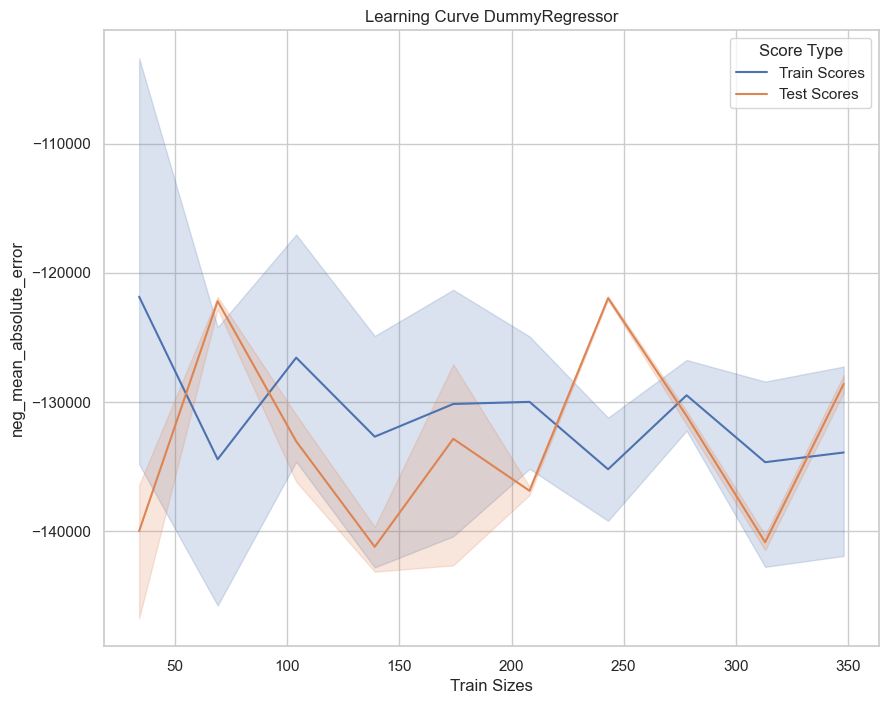

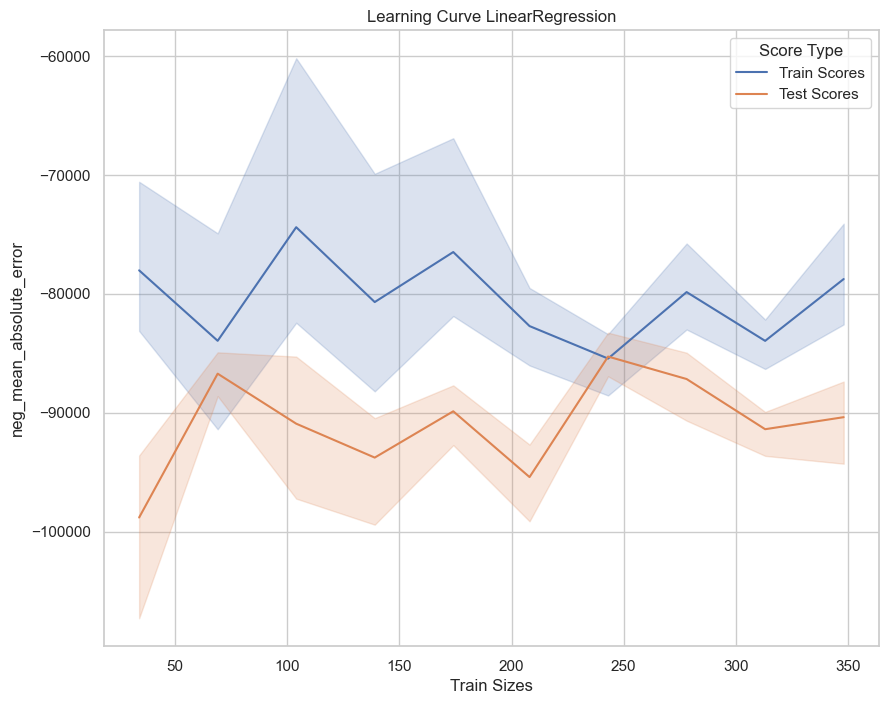

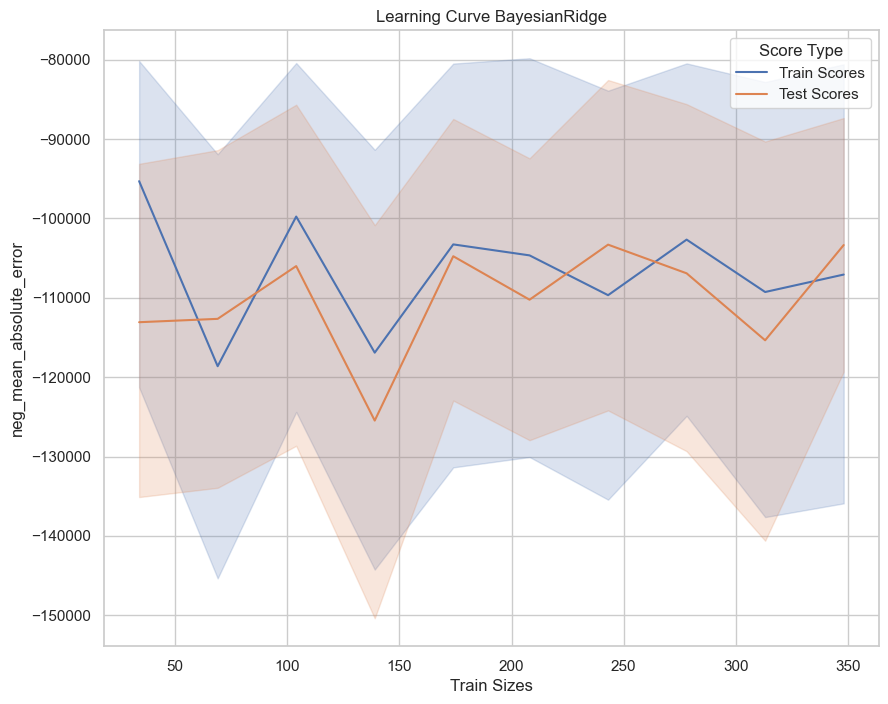

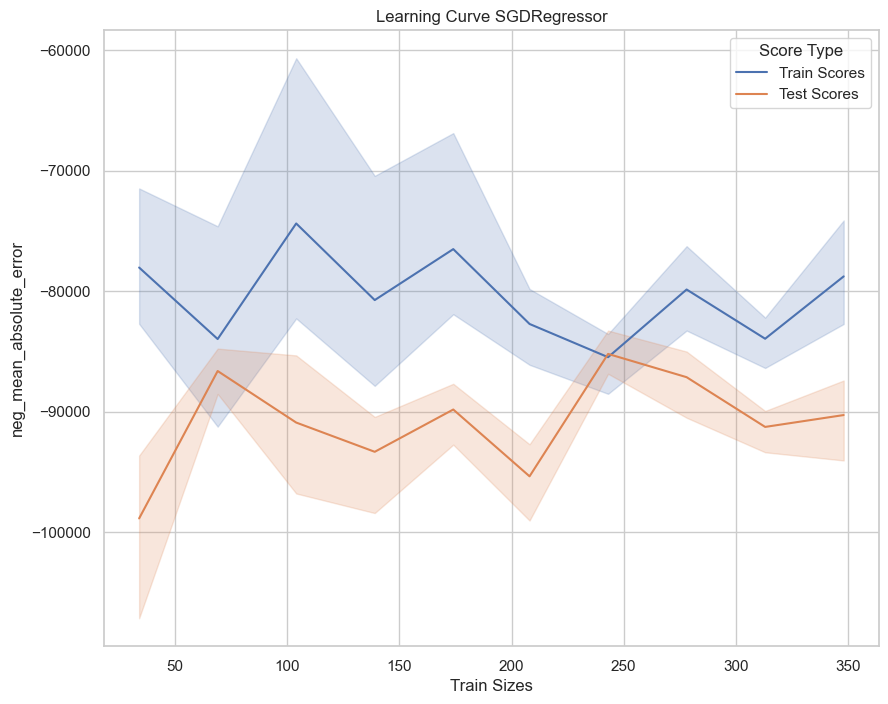

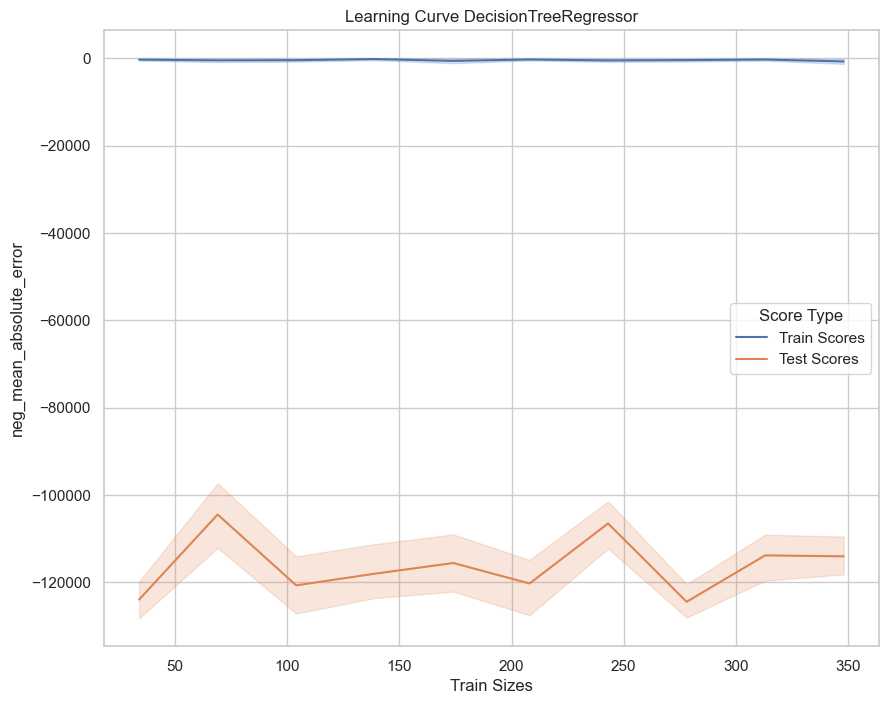

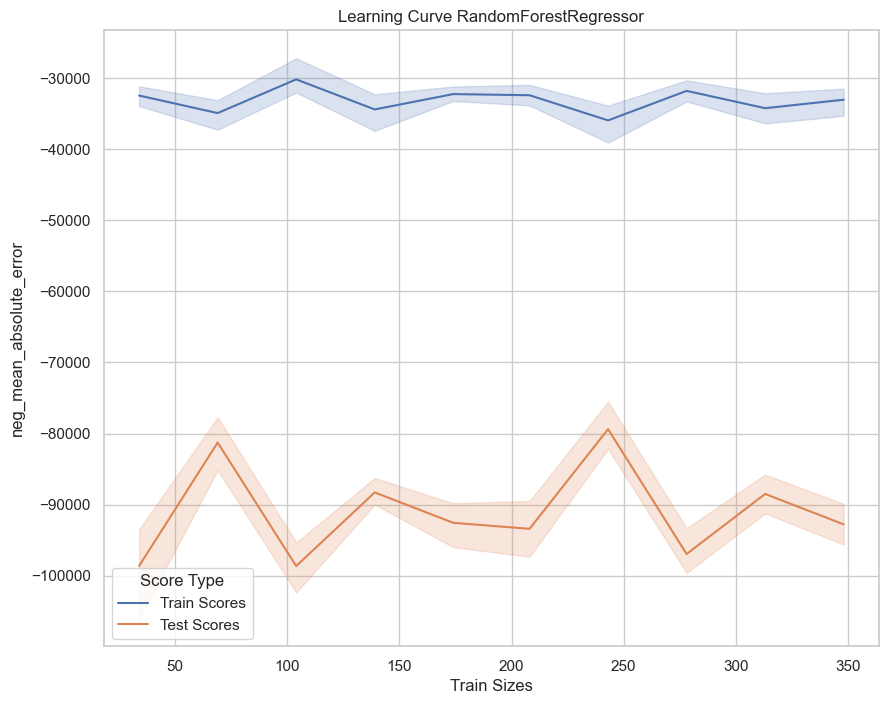

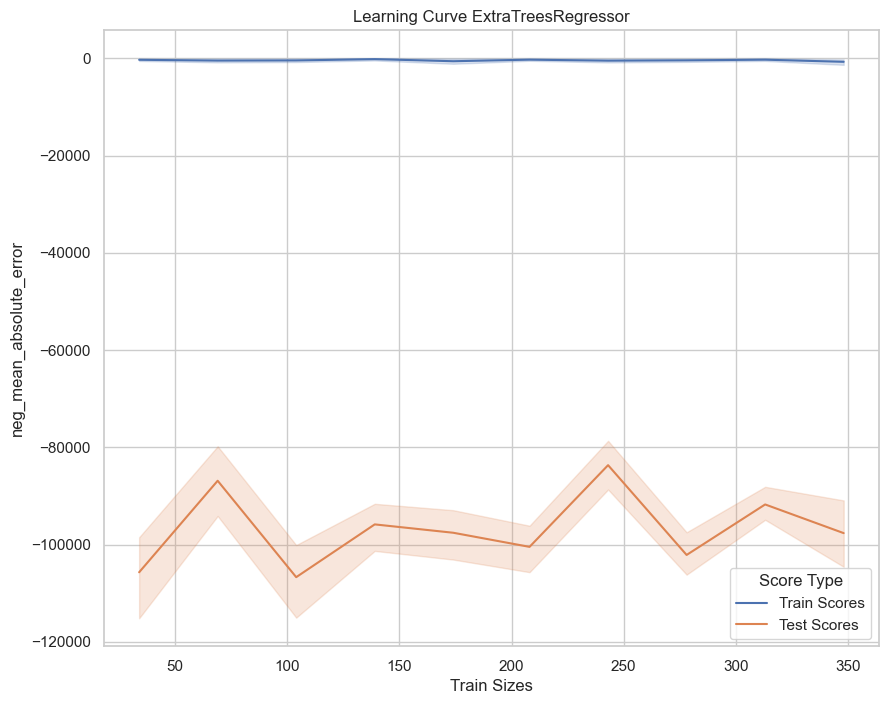

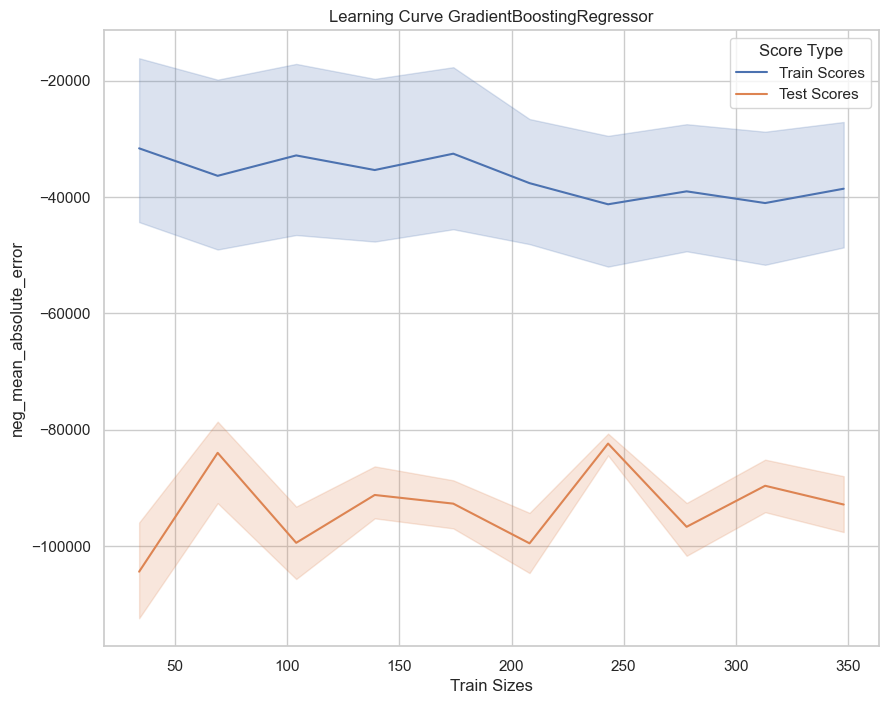

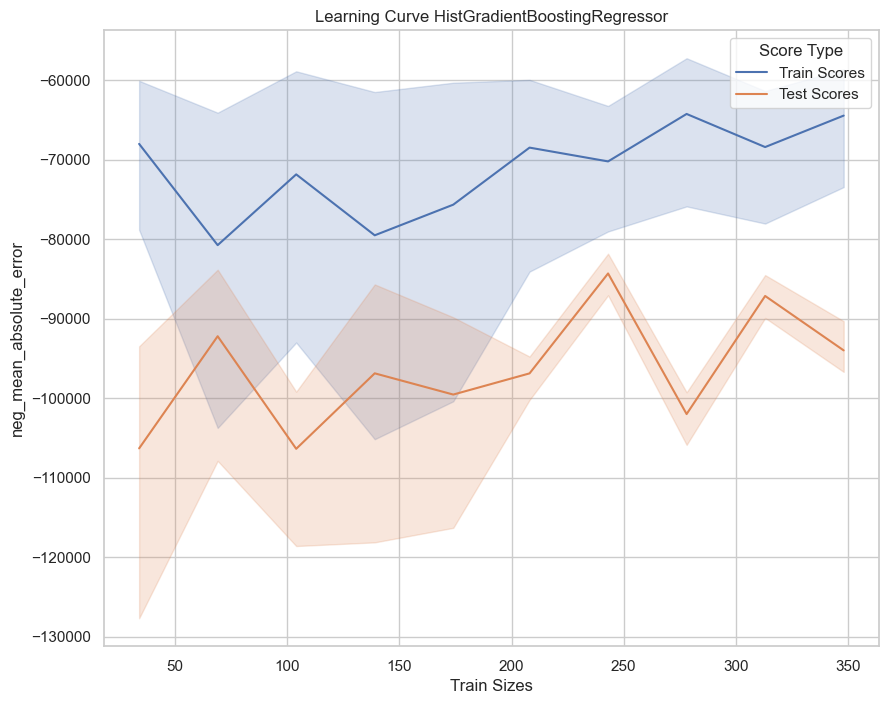

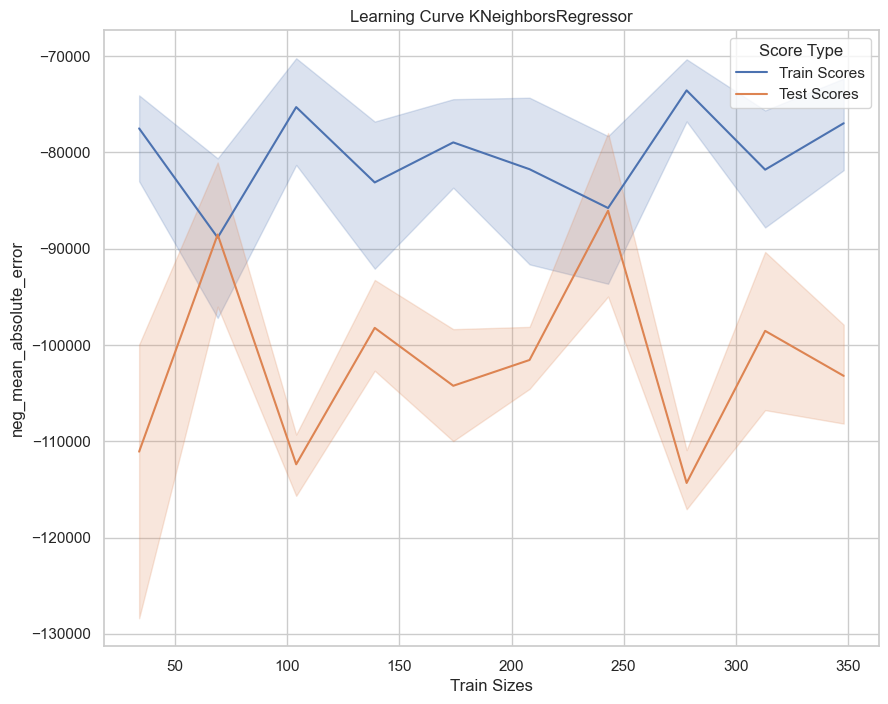

In [36]:
model_scores = model_evaluation_new(models, X_train, y_train, metrics)

In [37]:
model_scores_sorted = model_scores.sort_values(
    by=['test_neg_mean_absolute_error'],
    ascending=False
)

scores = (
    model_scores_sorted
    .style
    .apply(highlight_scores, subset=model_scores.columns[3:])
)

scores

,Model,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
2,BayesianRidge,0.013784,0.014402,-83969.736583,-87616.272964,-0.187189,-0.194507,-13248285043.084454,-14408943933.132141,0.569908,0.517089
1,LinearRegression,0.038266,0.008006,-83991.482365,-87845.904861,-0.186835,-0.194569,-13237821543.622597,-14448883499.469086,0.570248,0.514511
3,SGDRegressor,0.016307,0.005809,-84002.009103,-87910.758376,-0.186850,-0.194683,-13238483761.181232,-14465577415.123041,0.570227,0.513657
7,GradientBoostingRegressor,0.175561,0.011329,-54963.417982,-89082.029944,-0.126728,-0.198318,-5324925529.926262,-15209026665.360821,0.826718,0.487017
8,HistGradientBoostingRegressor,0.371185,0.014628,-61243.702085,-90526.831101,-0.135239,-0.199104,-7204842269.570787,-15684983186.407993,0.765920,0.464643
5,RandomForestRegressor,0.408654,0.032593,-33100.035337,-91478.534686,-0.074161,-0.202586,-2069919950.643463,-15930505713.404827,0.932731,0.459309
9,KNeighborsRegressor,0.018241,0.019200,-74309.310477,-92780.624305,-0.160961,-0.199996,-11022137289.968555,-17620344801.637321,0.642271,0.409316
6,ExtraTreesRegressor,0.291747,0.028584,-823.761651,-97156.442917,-0.002346,-0.214593,-36790686.073511,-17728484512.820026,0.998786,0.382539
4,DecisionTreeRegressor,0.015313,0.004803,-823.761651,-118309.091223,-0.002346,-0.256284,-36790686.073511,-27029891376.802979,0.998786,0.027551
0,DummyRegressor,0.011610,0.014239,-130927.690103,-131269.300470,-0.280604,-0.281349,-32445293022.096382,-32619596544.572044,-0.053152,-0.064946


**How did you select which learning algorithms to use?**

Lets break down our results for each model:

- Linear Models: 
    - All three models have low variance
    - Their MAE test scores have little difference
    - The models are not that overfitted to the data

- DecisionTree Models: 
    - The Decision Tree Regressor appears to also have a very high variance
    - The model also seemes to be overfitting the data

- Ensemble Models: 
    - The RandomForestRegressor performs better compared to the ExtraTreesRegressor as seen from their MAE scores
    - Both models have relatively high variance, as seen with the large distance between the train and test(cv) scores
    - The ExtraTreesRegressor seems to be severely overfitted to the data compared to the RandomFOrestRegressor, however overfitting still occurs
    - The GradientBoostingRegressor performs slightly better compared to the HistGradientBoostingRegressor - They both have relatively lower variance compared to the ensemble tree models, 
    - They still however, suffer from overfitting (though not that much)


- Distance Based Models: 
    - The KNeighborsRegressor also seems to have relatively high variance
    - Not that overfitted to data
    - Average score amongst models

Overall, we can tell that all models performances are relatively poor, however if we look at the numbers, we see that for MAE, BayesianRidge comes out on top, followed by the rest of the linear models. The next best performers would be the gradient boosting models, the K Neighbors model, the RandomForest and ExtraTrees models and lastly the Decision Tree model.

As we do not have convincing results thus far, and there are still many ways we can improve the models, it may not be best to select a model as of now. Thus, we will carry out steps to improve our models and select one at the end to be compared (with a dummy baseline) and evaluated on using unseen data (test set)

Further model selection is technically a form a model improvement, but the final model improvement will be implemented once a suitable candidate model has been chose

# Further Model Selection

There are a few things to be implemented/experimented with for further model selection:
<br>
1) Data Transformation
2) Feature Scaling Methods
3) Regularization (HistGradientBoostingRegressor)
4) Feature Engineering

* We will perform these steps and choose the most suitable model(s) at the end

**Data Transformation**

- From our EDA, wo observed that price follows a normal log distribution. Hence, we will apply log transformation to our target variable to observe if it improves the performance of our models

In [38]:
models = [
    DummyRegressor(),
    LinearRegression(), 
    BayesianRidge(), 
    SGDRegressor(),
    DecisionTreeRegressor(), 
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    HistGradientBoostingRegressor(),
    KNeighborsRegressor()
]

names = [
    'DummyRegressor',
    'LinearRegression', 
    'BayesianRidge', 
    'SGDRegressor',
    'DecisionTreeRegressor', 
    'RandomForestRegressor',
    'ExtraTreesRegressor',
    'GradientBoostingRegressor',
    'HistGradientBoostingRegressor',
    'KNeighborsRegressor'
]


model_scores_log_final = []

for model in models:
    reg = Pipeline([
        ('Data Preprocessing', ss),
        ('Model', model)
    ])
    ttr = TransformedTargetRegressor(reg, func=np.log, inverse_func=np.exp)
    model_scores_log = model_evaluation_single(ttr, X_train, y_train, metrics, curve=False) 
    model_scores_log_final.append(model_scores_log)

model_scores_log_final = pd.concat(model_scores_log_final, axis=0)
model_scores_log_final.insert(0, 'Models', names)
model_scores_log_final.reset_index(drop=True, inplace=True)

In [39]:
model_scores_sorted_log = model_scores_log_final.sort_values(
    by=['test_neg_mean_absolute_error'],
    ascending=False
)

scores_log = (
    model_scores_sorted_log
    .style
    .apply(highlight_scores, subset=model_scores_log.columns[2:])
)

scores_log

,Models,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
7,GradientBoostingRegressor,0.149665,0.012204,-55888.431363,-86343.083891,-0.121815,-0.187614,-5967870919.207568,-14687953658.732111,0.806097,0.512516
8,HistGradientBoostingRegressor,0.288348,0.015087,-59036.658644,-87290.450835,-0.125716,-0.188063,-7170331969.585027,-15091889472.478291,0.767076,0.489462
5,RandomForestRegressor,0.432699,0.033290,-33286.522011,-89373.733822,-0.069855,-0.193997,-2424584475.575637,-15607317164.748163,0.921386,0.481215
2,BayesianRidge,0.011422,0.008282,-86519.313217,-90063.427271,-0.184620,-0.191819,-14480295975.875164,-15797814026.303165,0.530158,0.477521
3,SGDRegressor,0.010936,0.010641,-86707.302816,-90387.445189,-0.184268,-0.191401,-14600375553.397543,-16034269982.773062,0.526272,0.469614
1,LinearRegression,0.015774,0.011279,-86766.118892,-90526.458259,-0.184751,-0.192353,-14582079403.840780,-15990510907.139538,0.526867,0.469781
9,KNeighborsRegressor,0.011268,0.015357,-74587.126688,-92547.950880,-0.156152,-0.194864,-11801716605.215439,-17975485438.110985,0.617191,0.403420
6,ExtraTreesRegressor,0.440778,0.027451,-823.761651,-96852.266429,-0.002323,-0.211420,-37019523.828792,-17651318460.350868,0.998778,0.392228
4,DecisionTreeRegressor,0.010685,0.009693,-823.761651,-113779.172072,-0.002323,-0.243883,-37019523.828791,-25035214251.797142,0.998778,0.117349
0,DummyRegressor,0.009266,0.012722,-131243.106973,-131611.581028,-0.288847,-0.289714,-31645926579.730385,-31818459794.893227,-0.027095,-0.042439


- Seems like there are some changes in our scores
- Since we used the TransformedTargetRegressor, we can obtain the score of our model on the original scale after performing log transformation on our target variable
- Hence, let's find the difference in score and see which model improved the most

In [40]:
df_diff = model_scores_log_final.iloc[:, 3:] - model_scores.iloc[:, 3:]
score_diff = pd.concat([model_scores_log_final.iloc[:, 0], df_diff], axis=1)

In [41]:
score_diff_sorted = score_diff.sort_values(
    by=['test_neg_mean_absolute_error'],
    ascending=False
)

score_difference = (
    score_diff_sorted
    .style
    .apply(highlight_scores, subset=model_scores_log.columns[2:])
)

score_difference

,Models,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
4,DecisionTreeRegressor,-0.000000,4529.919151,0.000023,0.012401,-228837.755281,1994677125.005836,-0.000008,0.089798
8,HistGradientBoostingRegressor,2207.043441,3236.380266,0.009524,0.011042,34510299.985761,593093713.929703,0.001156,0.024819
7,GradientBoostingRegressor,-925.013381,2738.946053,0.004913,0.010704,-642945389.281306,521073006.628710,-0.020621,0.025500
5,RandomForestRegressor,-186.486674,2104.800864,0.004306,0.008589,-354664524.932174,323188548.656664,-0.011345,0.021906
6,ExtraTreesRegressor,-0.000000,304.176488,0.000023,0.003173,-228837.755281,77166052.469158,-0.000008,0.009689
9,KNeighborsRegressor,-277.816212,232.673425,0.004808,0.005132,-779579315.246883,-355140636.473663,-0.025080,-0.005896
0,DummyRegressor,-315.416870,-342.280558,-0.008243,-0.008365,799366442.365997,801136749.678818,0.026057,0.022507
2,BayesianRidge,-2549.576635,-2447.154308,0.002569,0.002688,-1232010932.790710,-1388870093.171024,-0.039750,-0.039568
3,SGDRegressor,-2705.293713,-2476.686813,0.002582,0.003282,-1361891792.216311,-1568692567.650021,-0.043955,-0.044043
1,LinearRegression,-2774.636527,-2680.553398,0.002085,0.002216,-1344257860.218184,-1541627407.670452,-0.043381,-0.044729


In [42]:
models = [
    ("DummyRegressor", DummyRegressor()),
    ("LinearRegression", LinearRegression()), 
    ("BayesianRidge", BayesianRidge()), 
    ("SGDRegressor", SGDRegressor()),
    ("DecisionTreeRegressor", DecisionTreeRegressor()), 
    ("RandomForestRegressor", RandomForestRegressor()),
    ("ExtraTreesRegressor", ExtraTreesRegressor()),
    ("GradientBoostingRegressor", GradientBoostingRegressor()),
    ("HistGradientBoostingRegressor", HistGradientBoostingRegressor()),
    ("KNeighborsRegressor", KNeighborsRegressor())
]

# reg = Pipeline([
#         ('Data Preprocessing', ss),
#         ('Model', model)
#     ])
#     ttr = TransformedTargetRegressor(reg, func=np.log, inverse_func=np.exp)

In [43]:
# fig, ax = plt.subplots(10, 2, figsize=(20, 80))
# # DummyRegressor
# plot_learning_curve_comparison(DummyRegressor_pipeline, 'DummyRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[0,0])
# plot_learning_curve_comparison(DummyRegressor(), 'DummyRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[0,1])

# # LinearRegression
# plot_learning_curve_comparison(LinearRegression_pipeline, 'LinearRegression Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[1,0])
# plot_learning_curve_comparison(LinearRegression(), 'LinearRegression After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[1,1])

# # BayesianRidge
# plot_learning_curve_comparison(BayesianRidge_pipeline, 'BayesianRidge Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[2,0])
# plot_learning_curve_comparison(BayesianRidge(), 'BayesianRidge After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[2,1])

# # SGDRegressor
# plot_learning_curve_comparison(SGDRegressor_pipeline, 'SGDRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[3,0])
# plot_learning_curve_comparison(SGDRegressor(), 'SGDRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[3,1])

# # DecisionTreeRegressor
# plot_learning_curve_comparison(DecisionTreeRegressor_pipeline, 'DecisionTreeRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[4,0])
# plot_learning_curve_comparison(DecisionTreeRegressor(), 'DecisionTreeRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[4,1])

# # RandomForestRegressor
# plot_learning_curve_comparison(RandomForestRegressor_pipeline, 'RandomForestRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[5,0])
# plot_learning_curve_comparison(RandomForestRegressor(), 'RandomForestRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[5,1])

# # ExtraTreesRegressor
# plot_learning_curve_comparison(ExtraTreesRegressor_pipeline, 'ExtraTreesRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[6,0])
# plot_learning_curve_comparison(ExtraTreesRegressor(), 'ExtraTreesRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[6,1])

# # GradientBoostingRegressor
# plot_learning_curve_comparison(GradientBoostingRegressor_pipeline, 'GradientBoostingRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[7,0])
# plot_learning_curve_comparison(GradientBoostingRegressor(), 'GradientBoostingRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[7,1])

# # HistGradientBoostingRegressor
# plot_learning_curve_comparison(HistGradientBoostingRegressor_pipeline, 'HistGradientBoostingRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[8,0])
# plot_learning_curve_comparison(HistGradientBoostingRegressor(), 'HistGradientBoostingRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[8,1])

# #KNeighborsRegressor
# plot_learning_curve_comparison(KNeighborsRegressor_pipeline, 'KNeighborsRegressor Before Log', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[9,0])
# plot_learning_curve_comparison(KNeighborsRegressor(), 'KNeighborsRegressor After Log', X_train, y_train_log, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[9,1])

- We see that log transformation has improved the score of the DecisionTreeRegressor the most followed by HistGradientBoostingRegressor and GradientBoostingRegressor
- Besides that, the log transformation also managed to make GradientBoostingRegressor the best performing model so far (lowest MAE score so far), followed by HistGradientBoostingRegressor
- The other ensemble models also appear to show signs of improvement
- In contrast, this transformation has caused the scores of our distance (KNeigborsRegressor) and linear (LinearRegression, BayesianRidge, SGDRegressor) models to deprove

**Feature Scaling Methods**

Some models may be sensitive to the scaling applied to the data. Thus, we will apply various feature scaling methods to observe how they affect various model's performances. 

- As we still have many models to choose from, comparing the results of every model after applying various scaling methods will be a hassle
- Hence, I will choose models to represent their classes, in order to compare results when applying different scaling methods
- These models are: LinearRegression, HistGradientBoostingRegressor, DecisionTreeRegressor and KNeighborsRegressor

First, let's obtain the results of the model when no scaling is applied

In [44]:
scaling_non = [LinearRegression(), HistGradientBoostingRegressor(), DecisionTreeRegressor(), KNeighborsRegressor()]
names = ['LinearRegression', 'HistGradientBoostingRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor']

scores_sn_final = []

for model in scaling_non:
    score_sn = model_evaluation_single(model, X_train, y_train, metrics, curve=False) 
    scores_sn_final.append(score_sn)

scores_sn_final = pd.concat(scores_sn_final, axis=0)
scores_sn_final.insert(0, 'Models', names)
#scores_sn_final

Now let's obtain the results when the different scalers are applied:
- StandardScaler()
- RobustScaler()
- MinMaxScaler()
- QuantileTransformer()

In [45]:
models = [LinearRegression(), HistGradientBoostingRegressor(), DecisionTreeRegressor(), KNeighborsRegressor()]
names_ss = ['LinearRegression(StandardScaler)', 'HistGradientBoostingRegressor(StandardScaler)', 'DecisionTreeRegressor(StandardScaler)', 'KNeighborsRegressor(StandardScaler)']
names_rs = ['LinearRegression(RobustScaler)', 'HistGradientBoostingRegressor(RobustScaler)', 'DecisionTreeRegressor(RobustScaler)', 'KNeighborsRegressor(RobustScaler)']
names_mms = ['LinearRegression(MinMaxScaler)', 'HistGradientBoostingRegressor(MinMaxScaler)', 'DecisionTreeRegressor(MinMaxScaler)', 'KNeighborsRegressor(MinMaxScaler)']
names_qt = ['LinearRegression(QuantileTransformer)', 'HistGradientBoostingRegressor(QuantileTransformer)', 'DecisionTreeRegressor(QuantileTransformer)', 'KNeighborsRegressor(QuantileTransformer)']

# StandardScaler
ss = StandardScaler()
result_ss = []

for model in models:
    reg = Pipeline([
        ('Scaler', ss),
        ('Model', model)
    ])
    score_ss = model_evaluation_single(reg, X_train, y_train, metrics, curve=False) 
    result_ss.append(score_ss)

result_ss = pd.concat(result_ss, axis=0)
result_ss.insert(0, 'Models', names_ss)

# RobustScaler
rs = RobustScaler()
result_rs = []

for model in models:
    reg = Pipeline([
        ('Scaler', rs),
        ('Model', model)
    ])
    score_rs = model_evaluation_single(reg, X_train, y_train, metrics, curve=False) 
    result_rs.append(score_rs)

result_rs = pd.concat(result_rs, axis=0)
result_rs.insert(0, 'Models', names_rs)

# MinMaxScaler
mms = MinMaxScaler()
result_mms = []

for model in models:
    reg = Pipeline([
        ('Scaler', mms),
        ('Model', model)
    ])
    score_mms = model_evaluation_single(reg, X_train, y_train, metrics, curve=False) 
    result_mms.append(score_mms)

result_mms = pd.concat(result_mms, axis=0)
result_mms.insert(0, 'Models', names_mms)

# QuantileTransformer
qt = QuantileTransformer()
result_qt = []

for model in models:
    reg = Pipeline([
        ('Scaler', qt),
        ('Model', model)
    ])
    score_qt = model_evaluation_single(reg, X_train, y_train, metrics, curve=False) 
    result_qt.append(score_qt)

result_qt = pd.concat(result_qt, axis=0)
result_qt.insert(0, 'Models', names_qt)

scaler_results = pd.concat([scores_sn_final, result_ss, result_rs, result_mms, result_qt], axis=0)
scaler_results.reset_index(drop=True, inplace=True)

In [46]:
scaler_results_sorted = scaler_results.sort_values(
    by=['Models']
)

scaler_results_sorted

,Models,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
2,DecisionTreeRegressor,0.008008,0.011666,-823.761651,-121838.824765,-0.002346,-0.265399,-3.679069e+07,-2.741239e+10,0.998786,0.013396
14,DecisionTreeRegressor(MinMaxScaler),0.014401,0.009600,-823.761651,-119919.456217,-0.002346,-0.260950,-3.679069e+07,-2.764618e+10,0.998786,0.003408
18,DecisionTreeRegressor(QuantileTransformer),0.022084,0.013260,-823.761651,-117163.873668,-0.002346,-0.254240,-3.679069e+07,-2.671791e+10,0.998786,0.041628
10,DecisionTreeRegressor(RobustScaler),0.014525,0.012630,-823.761651,-118033.196499,-0.002346,-0.256494,-3.679069e+07,-2.676605e+10,0.998786,0.028417
6,DecisionTreeRegressor(StandardScaler),0.012209,0.011200,-823.761651,-119190.811442,-0.002346,-0.258474,-3.679069e+07,-2.722222e+10,0.998786,0.008730
1,HistGradientBoostingRegressor,0.284810,0.013885,-61243.702085,-90710.004394,-0.135239,-0.199463,-7.204842e+09,-1.571537e+10,0.765920,0.463775
13,HistGradientBoostingRegressor(MinMaxScaler),0.290645,0.015315,-61243.702085,-90702.884400,-0.135239,-0.199445,-7.204842e+09,-1.571533e+10,0.765920,0.463776
17,HistGradientBoostingRegressor(QuantileTransfor...,0.311110,0.014402,-61243.702085,-90346.615518,-0.135239,-0.198863,-7.204842e+09,-1.559340e+10,0.765920,0.467596
9,HistGradientBoostingRegressor(RobustScaler),0.308658,0.019200,-61243.702085,-90674.516187,-0.135239,-0.199432,-7.204842e+09,-1.571072e+10,0.765920,0.463938
5,HistGradientBoostingRegressor(StandardScaler),0.364986,0.018391,-61243.702085,-90526.831101,-0.135239,-0.199104,-7.204842e+09,-1.568498e+10,0.765920,0.464643


Observing the scores of our models, we can observe that there is very little no significant difference between various scaling methods, with the execption of KNeighborsRegressor(MinMaxScaler), which produced a drop in performance of the model.

Hence, we will just keep the original scaling method we implemented: Standardization

**Regularization (HistGradientBoostingRegressor)**

- We've already seen that log transformtion of the target variable helps improve the score of our HistGradientBoostingRegressor. 
- However, HistGradientBoostingRegressor also supports a form of L2 Regualrization. 
- L2 Regularization incentivises the model to find simpler solutions as it penalizes the complexity of the model. 
- We implement this in hopes that it will reduce the variance of the model.

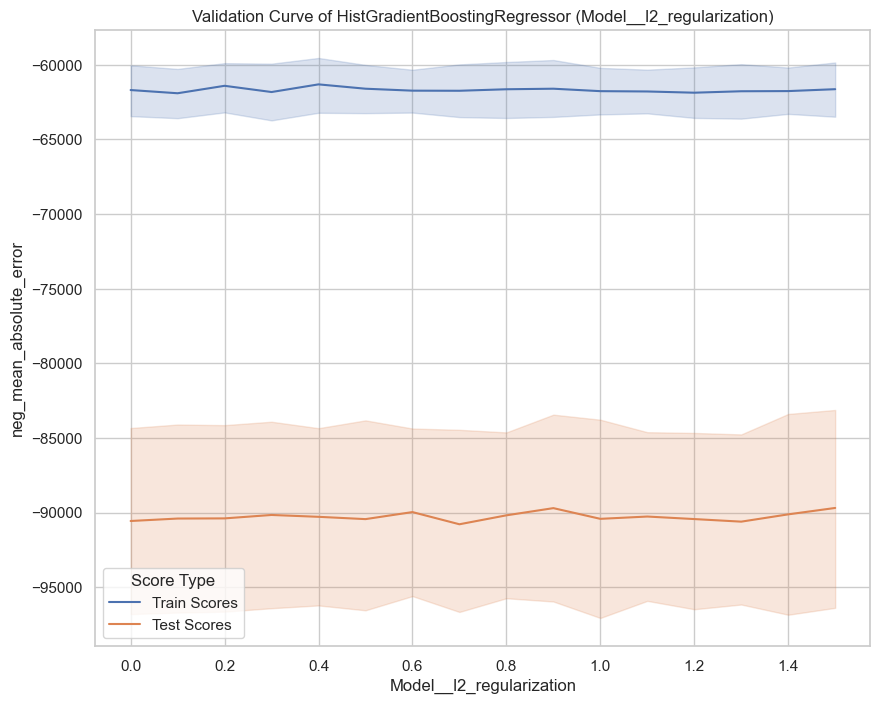

In [47]:
reg = Pipeline([
    ('Scaler', ss),
    ('Model', HistGradientBoostingRegressor())
])

plot_validation_curve(reg, X=X_train, y=y_train, param_name="Model__l2_regularization", param_range=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5])

Looking the the validation curve, it's clear that regularization does not seem to help reduce variance in our model and improve it. Hence, we probably would not be implementing it

**Total Area (Feature Engineering)**

**Did you process the features in any way?**

- For this segment, I will create a new feature: Total Area
- Total Area is defined by: Housing Area multiplied by Stories
- The aim of feature engineering is for our model to capture any new relationships between our feature and target variable
- This in turn would hopefully help improve out model's performance
- Note: I will test out Total Area as a feature on the top two models after log transformation: GradientBoostingRegressor and HistGradientBoostingRegressor
- After that I will compare their scores

In [48]:
# Create the new feature
X_copy = X.copy()
y_copy = y.copy()

X_copy['Total_Area'] = X_copy['House Area (sqm)'] * X_copy['Stories']
X_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
House Area (sqm),545.0,515.054128,217.014102,165.0,360.0,460.0,636.0,1620.0
No. of Bedrooms,545.0,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
No. of Toilets,545.0,1.286239,0.502470,1.0,1.0,1.0,2.0,4.0
Stories,545.0,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
Chicago,545.0,0.108257,0.310990,0.0,0.0,0.0,0.0,1.0
Denver,545.0,0.163303,0.369981,0.0,0.0,0.0,0.0,1.0
New York,545.0,0.289908,0.454136,0.0,0.0,0.0,1.0,1.0
Seattle,545.0,0.245872,0.430998,0.0,0.0,0.0,0.0,1.0
semi-furnished,545.0,0.416514,0.493434,0.0,0.0,0.0,1.0,1.0
unfurnished,545.0,0.326606,0.469402,0.0,0.0,0.0,1.0,1.0


In [49]:
# Train Test Split
X_train_fe, X_test_test_fe, y_train_fe, y_test_fe = train_test_split(X_copy, y_copy, test_size=.2, shuffle=True,random_state = 42)

Without the addition of Total Area:

In [50]:
# Without new feature
feature_non = [GradientBoostingRegressor(), HistGradientBoostingRegressor()]
names = ['GradientBoostingRegressor', 'HistGradientBoostingRegressor']

result_nf = []

for model in feature_non:
    reg = Pipeline([
        ('Data Preprocessing', ss),
        ('Model', model)
    ])
    score_nf = model_evaluation_single(reg, X_train, y_train, metrics, curve=False) 
    result_nf.append(score_nf)

result_nf = pd.concat(result_nf, axis=0)
result_nf.insert(0, 'Models', names)

In [51]:
result_nf

,Models,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
0,GradientBoostingRegressor,0.150104,0.010106,-54963.417982,-88874.346147,-0.126728,-0.197812,-5.324926e+09,-1.518415e+10,0.826718,0.488436
0,HistGradientBoostingRegressor,0.238511,0.011868,-61243.702085,-90526.831101,-0.135239,-0.199104,-7.204842e+09,-1.568498e+10,0.765920,0.464643


With the addition of Total Area as a new feature:

In [52]:
# With new feature
models = [GradientBoostingRegressor(), HistGradientBoostingRegressor()]
name = ['GradientBoostingRegressor(Total Area)', 'HistGradientBoostingRegressor(Total Area)']

result_feature = []

for model in models:
    reg = Pipeline([
        ('Scaler', ss),
        ('Model', model)
    ])
    score_feature = model_evaluation_single(reg, X_train_fe, y_train_fe, metrics, curve=False) 
    result_feature.append(score_feature)

result_feature = pd.concat(result_feature, axis=0)
result_feature.insert(0, 'Models', name)

In [53]:
result_feature

,Models,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
0,GradientBoostingRegressor(Total Area),0.150743,0.008216,-51865.772821,-89301.098746,-0.120101,-0.198594,-4.744943e+09,-1.556571e+10,0.845711,0.475968
0,HistGradientBoostingRegressor(Total Area),0.271531,0.016356,-55138.874196,-91304.483761,-0.121569,-0.201508,-6.004672e+09,-1.570387e+10,0.805023,0.465102


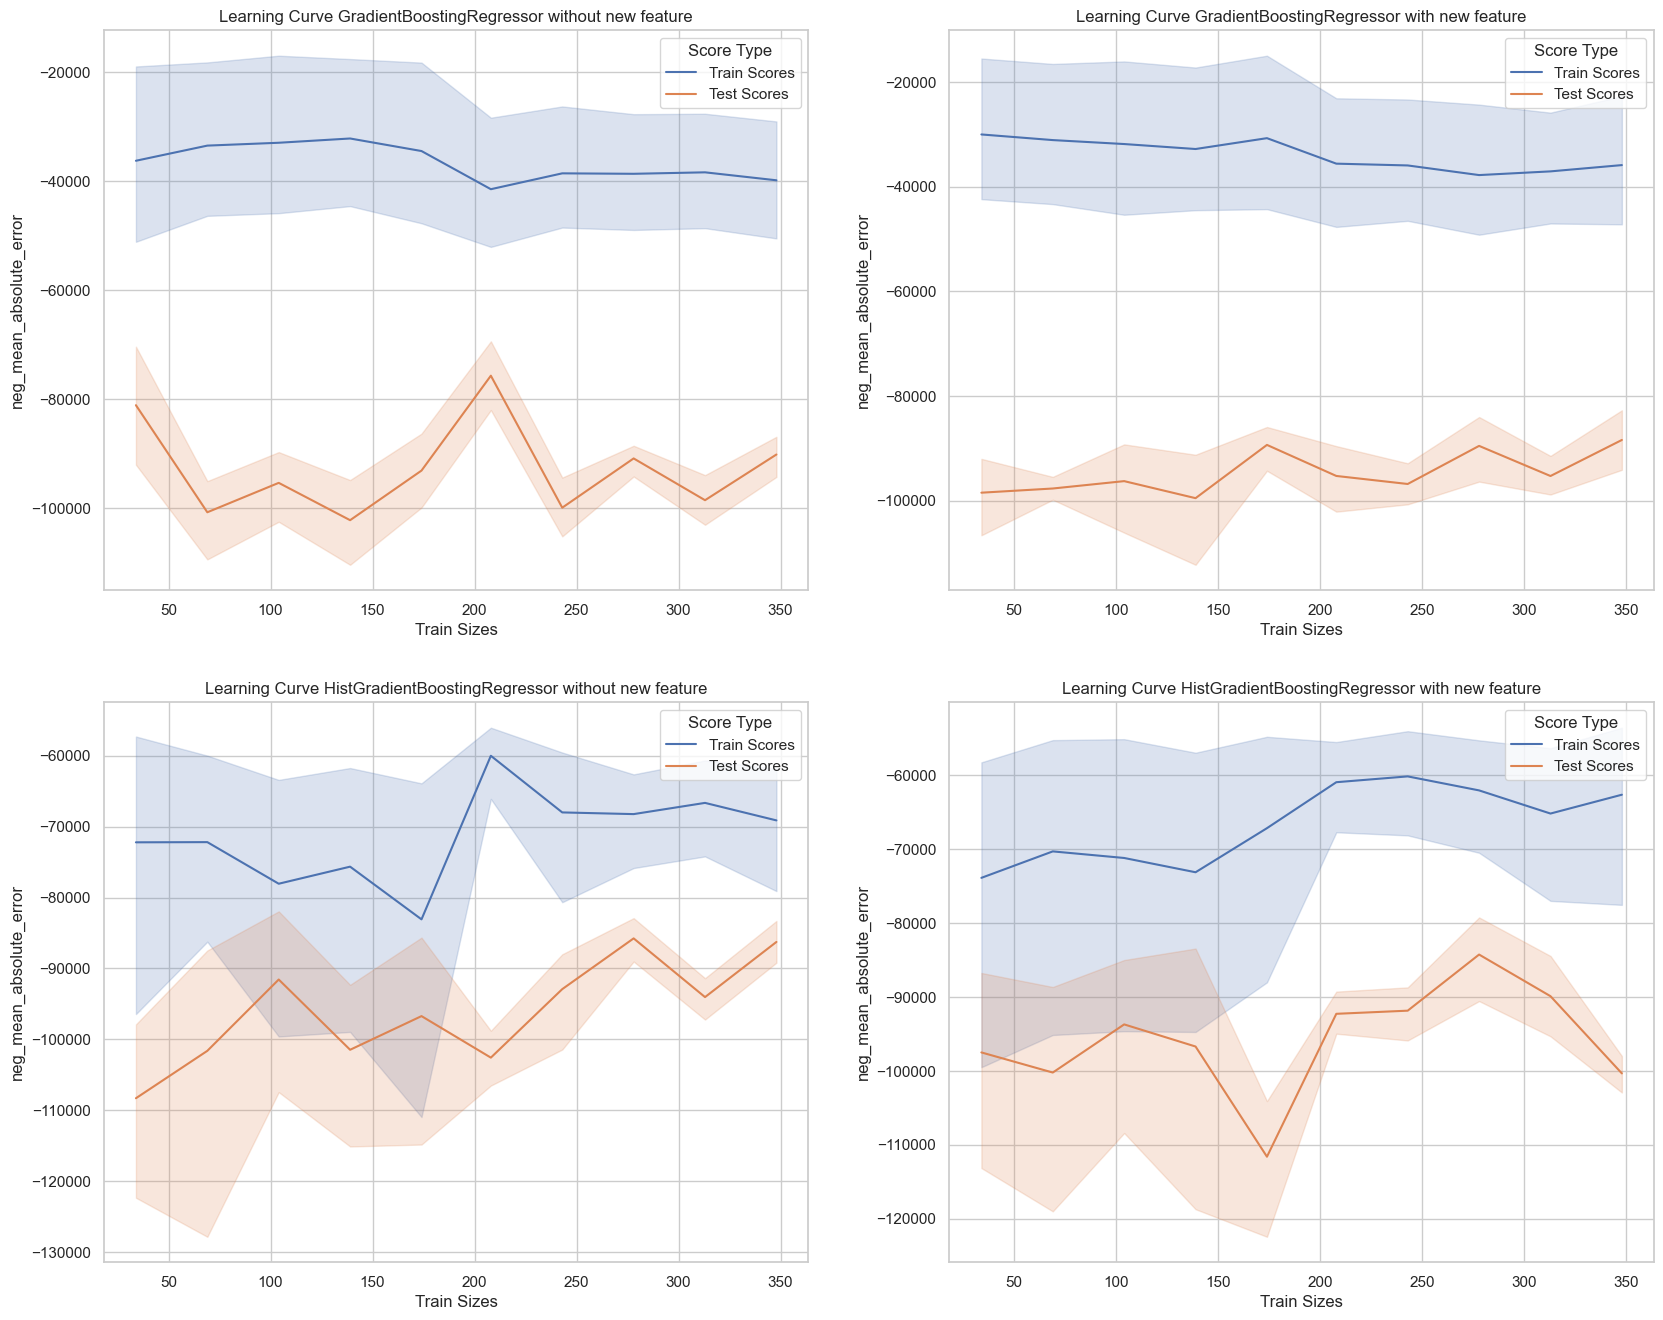

In [54]:
# After that compare the scores, find difference
# Can plot graph as well to compare, BUT do that for the log transformation segment first and apply it here
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# GradientBoostingRegressor
plot_learning_curve_comparison(GradientBoostingRegressor_pipeline, 'GradientBoostingRegressor without new feature', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[0,0])
plot_learning_curve_comparison(GradientBoostingRegressor_pipeline, 'GradientBoostingRegressor with new feature', X_train_fe, y_train_fe, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[0,1])

# HistGradientBoostingRegressor
plot_learning_curve_comparison(HistGradientBoostingRegressor_pipeline, 'HistGradientBoostingRegressor without new feature', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[1,0])
plot_learning_curve_comparison(HistGradientBoostingRegressor_pipeline, 'HistGradientBoostingRegressor with new feature', X_train_fe, y_train_fe, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[1,1])

In conclusion, it seems that Total Area as a new feature doesnt really help or affect our model's peroformance significantly. Comparing the scores before and after featre engineering even shows us that Total Area as a feature causes both of our model's performance to deprove. Thus, we will not be implementing this.

# **EXTRA**

**Feature Selection**

- We will attempt to reduce the number of features in our data
- This way we remove less powerful predictors and avoid our models from overfitting

In [55]:
len(X_train.columns) # we have 11 features initially

10

**Recursive Feature Elimination (RFE)**

RFE is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached.


In [56]:
# results = []
# for no_features in (10,9,8):
#   reg = Pipeline([
#       ('Data Preprocessing', preprocessor),
#       ('Feature Selection', RFE(RandomForestRegressor(), n_features_to_select=no_features)),
#       ('Model', RandomForestRegressor(random_state=42))
#   ])
#   result = model_evaluation_single(reg, X_train, y_train, metrics, curve=False)
  
#   results.append(result)    

In [57]:
# reg1= Pipeline([
#       ('Data Preprocessing', preprocessor),
#       ('Feature Selection', RFE(RandomForestRegressor(), n_features_to_select=5)),
#       ('Model', RandomForestRegressor(random_state=42))
#   ])
# result1 = model_evaluation_single(reg1, X_train, y_train, metrics, curve=False)
# result1

In [58]:
# pd.DataFrame(results)

****

Now that further model selction is complete, our results are as follows:
- Of all tests we have done, only log transformation of the target variable has brought about an improvement in our models. Hence, we will be applying this to our final model
- The best performing models after model selection are: GradientBoostingRegressor and HistGradientBoostingRegressor
- Following this, we will perform hyperparameter tuning on both models
- The final model will be selected and evaluated after model improvement

****

# Model Improvement (Hyperparameter Tuning)

**Did you try to tune the hyperparamters of the learning algorithm, and in that case how?**

Now we will perform hyperparameter tuning, which finds the optimal combination of hyperparameters of our models. At the same time we will be implementing log transformation of the target variable, which we doun was the best method from further model selection. 

We will carry out hyperparameter tuning using random search instead of grid search as it takes lesser time and computational power

In [59]:
reg_gbr = Pipeline([
    ('Data Preprocessing', StandardScaler()),
    ('Model', TransformedTargetRegressor(GradientBoostingRegressor(), func=np.log, inverse_func=np.exp))
])

reg_histgbr = Pipeline([
    ('Data Preprocessing', StandardScaler()),
    ('Model', TransformedTargetRegressor(HistGradientBoostingRegressor(), func=np.log, inverse_func=np.exp))
])

# # grid_search  = HalvingGridSearchCV(reg, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, resource="Model__regressor__max_iter", min_resources=10, max_resources=250)
# features_rf = [feature for feature in X_train.columns if feature !="yr_renovated"]
# features_gbm = [feature for feature in X_train.columns if feature not in {"floors", "bedrooms"}]

**GradientBoostingRegressor**

In [60]:
param_grid = {
    "Model__regressor__n_estimators" : [100, 150, 200, 250, 300, 350, 400, 500],
    "Model__regressor__learning_rate" : [0.01, 0.1, 0.5, 1.0],
    "Model__regressor__max_depth" : [1, 2, 3, 4, 5, 7, 9],
    "Model__regressor__subsample" : [0.5, 0.75, 1.0]
}
rscv_gbr = RandomizedSearchCV(reg_gbr, param_grid, scoring="neg_mean_absolute_error", n_iter=120, n_jobs=-1) # search across 120 combinations
rscv_gbr.fit(X_train, y_train)

rscv_gbr.best_params_

{'Model__regressor__subsample': 1.0,
 'Model__regressor__n_estimators': 400,
 'Model__regressor__max_depth': 2,
 'Model__regressor__learning_rate': 0.01}

In [61]:
score_rscv_gbr = model_evaluation_single(rscv_gbr, X_train, y_train, metrics, curve=False)
score_rscv_gbr

,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
0,273.815715,0.016157,-68801.418485,-83241.806453,-0.148711,-0.179473,-9.439340e+09,-1.405528e+10,0.693297,0.540573


**HistGradientBoostingRegressor**

In [62]:
param_grid = {
    "Model__regressor__max_depth" : [None, 7, 8, 9, 10, 11, 12, 13, 14],
    "Model__regressor__min_samples_leaf" : np.linspace(5, 100, 10, dtype=int),
    "Model__regressor__l2_regularization" : np.linspace(0, 2),
}
rscv_histgbr = RandomizedSearchCV(reg_histgbr, param_grid, scoring="neg_mean_absolute_error", n_iter=120, n_jobs=-1) # search across 120 combinations
rscv_histgbr.fit(X_train, y_train)

rscv_histgbr.best_params_

{'Model__regressor__min_samples_leaf': 36,
 'Model__regressor__max_depth': None,
 'Model__regressor__l2_regularization': 1.183673469387755}

In [63]:
score_rscv_histgbr = model_evaluation_single(rscv_histgbr, X_train, y_train, metrics, curve=False)
score_rscv_histgbr

,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
0,189.796405,0.027207,-62483.857073,-88462.140052,-0.133697,-0.190733,-8.262952e+09,-1.557678e+10,0.733272,0.478718


After performing hyperparameter tuning, we see that GradientBoostingRegressor is our top performing model, with the highest CV MAE test score. Tuning HistGradientBoostingRegressor also improves its performance, however it is unable to match GradientBoostingRegressor. 

# Comparing with dummy baseline 

**How well does your system compare to a dummy baseline?**

In [64]:
model_evaluation_single(DummyRegressor_pipeline, X_train, y_train, metrics, curve=False)

,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
0,0.01493,0.019392,-130927.690103,-131269.30047,-0.280604,-0.281349,-3.244529e+10,-3.261960e+10,-0.053152,-0.064946


In [65]:
compare_gbr = Pipeline([
    ('Data Preprocessing', StandardScaler()),
    ('Model', TransformedTargetRegressor(GradientBoostingRegressor(n_estimators=500, learning_rate= 0.01, max_depth=3, subsample=1.0), func=np.log, inverse_func=np.exp))
])

model_evaluation_single(compare_gbr, X_train, y_train, metrics, curve=False)

,fit_time,score_time,train_neg_mean_absolute_error,test_neg_mean_absolute_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,train_neg_mean_squared_error,test_neg_mean_squared_error,train_r2,test_r2
0,1.359295,0.042105,-65368.975683,-83067.597577,-0.141263,-0.180294,-8.410727e+09,-1.360657e+10,0.726828,0.551966


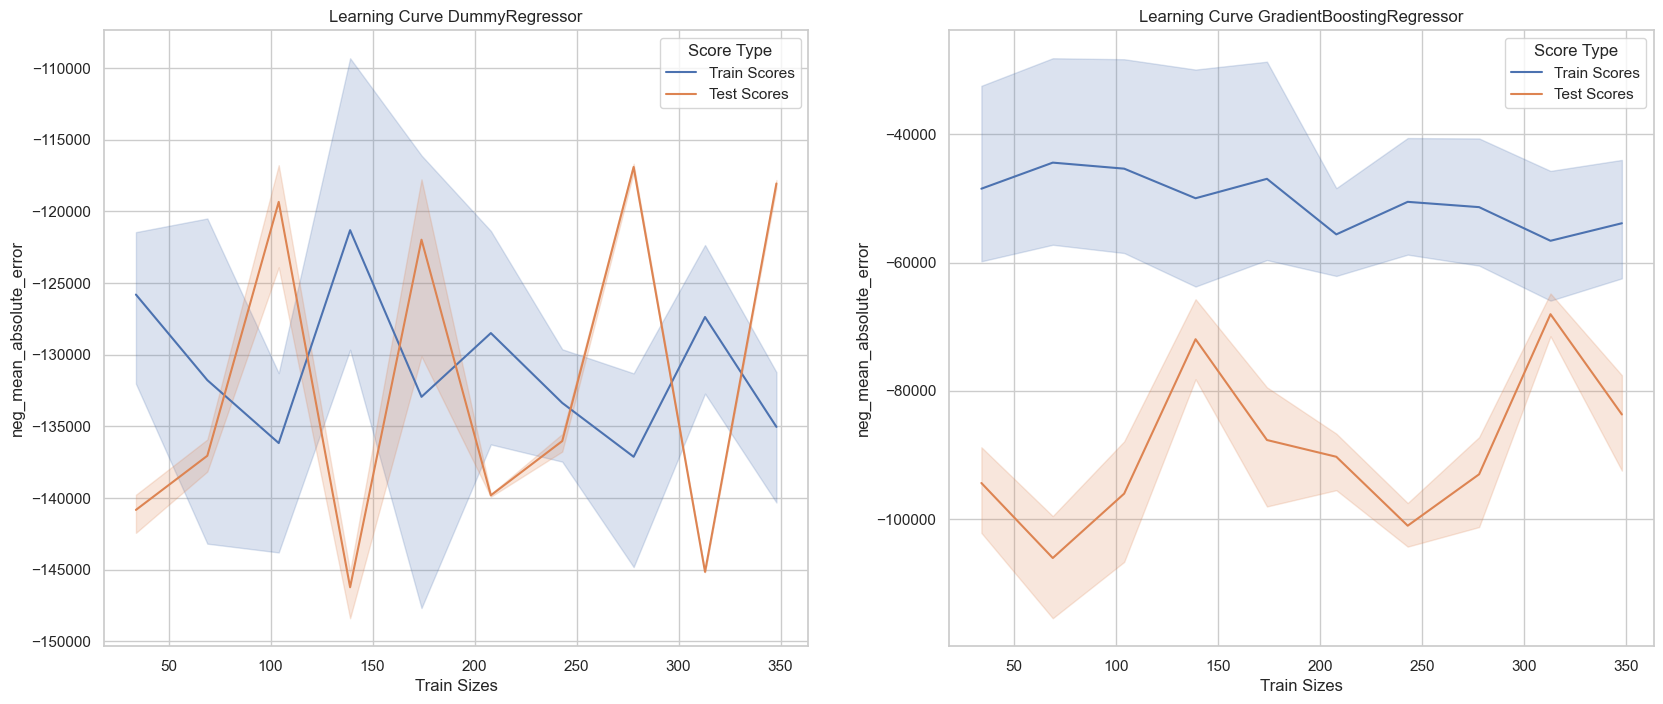

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# GradientBoostingRegressor
plot_learning_curve_comparison(DummyRegressor_pipeline, 'DummyRegressor', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[0])
plot_learning_curve_comparison(compare_gbr, 'GradientBoostingRegressor', X_train, y_train, metrics[0], KFold(n_splits=5, shuffle=True), ax=ax[1])

The baseline model predicts the median value (set to median as our data is skewed, therefore mediann is a more accurate predictor).

Observe that our model (GradientBoostingRegressor) performs much more better compared to the baseline model (DummyRegressor), with better scores all around and a much better fit

# Final Model

Now we will train the final model using everything we have learnt so far

In [67]:
reg_final = Pipeline([
    ('Data Preprocessing', StandardScaler()),
    ('Model', TransformedTargetRegressor(GradientBoostingRegressor(n_estimators=500, learning_rate= 0.01, max_depth=3, subsample=1.0), func=np.log, inverse_func=np.exp))
])

In [68]:
# reg_final.fit(X_train, y_train) 

# Model Evaluation

**How do you evaluate the quality of your system?**

Evaluate the final model on unseen data (test set)

In [69]:
reg_final.fit(X_train, y_train) 

y_pred = reg_final.predict(X_test)
y_pred_train = reg_final.predict(X_train)
mae_scores, mape_scores, rmse_scores, r2 = [], [], [], []
for (prediction, actual) in ((y_pred, y_test), (y_pred_train, y_train)):
  mae_scores.append(mean_absolute_error(actual, prediction))
  mape_scores.append(mean_absolute_percentage_error(actual, prediction))
  rmse_scores.append(np.sqrt(mean_squared_error(actual, prediction)))
  r2 = r2_score(actual, prediction)
  

final_scores = pd.DataFrame({
    "MAE" : mae_scores,
    "MAPE" : mape_scores,
    "RMSE" : rmse_scores,
    "R Squared" : r2
}, index=["Test", "Train"])
display(final_scores)

,MAE,MAPE,RMSE,R Squared
Test,115136.922463,0.244187,158401.753166,0.711986
Train,66800.172646,0.144040,94236.935628,0.711986


It seems that the model is definitely overfitting the data, but why is so?

**Can you say anything about the errors that the system makes?**

We can understand the errors of our models by creating a residual plot.

In [70]:
residuals = y_test - y_pred

In [71]:
x = np.mean(residuals)
print(f'The mean of residuals is {x}')

The mean of residuals is Price ($)    30449.247871
dtype: float64


c:\Users\HP\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


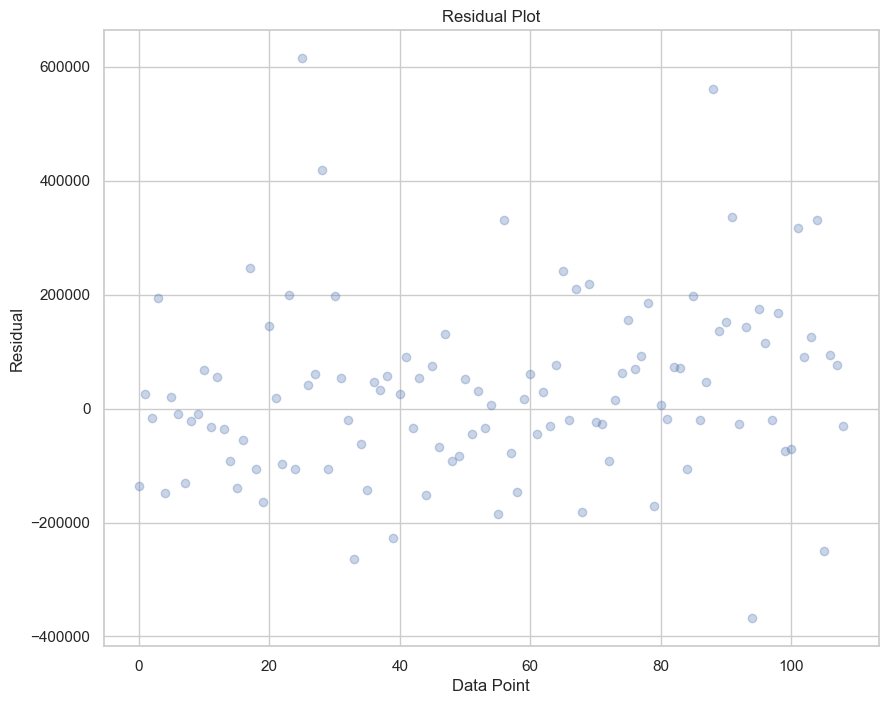

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=range(len(residuals)), y=residuals, alpha=.3)
ax.set_title("Residual Plot")
ax.set_ylabel("Residual")
ax.set_xlabel("Data Point")
plt.show()

It is hard to tell from the residual plot alone, but our model tends to under predict the value of a house. This is also shown by the fact that the mean of residuals is positive.